# Заняття 8

## Мета:
Дослідити різні архітектури генеративно-змагальних мереж (GAN) і практикуватися з налаштуванням параметрів для досягнення кращих результатів генерації зображень.

---

## Кроки для виконання завдання:

### 1. Вибір архітектур GAN:
- **DCGAN (Deep Convolutional GAN):** Реалізуйте DCGAN, що використовує згорткові шари для кращого захоплення просторових властивостей зображень.
- **WGAN (Wasserstein GAN):** Спробуйте реалізувати WGAN для покращення стабільності навчання та якості генерації.
- **Conditional GAN (cGAN):** Реалізуйте Conditional GAN, щоб навчитися генерувати зображення з додатковими умовами (наприклад, категорією).

### 2. Підготовка набору даних:
- Як в попередніх завданнях.

### 3. Налаштування архітектури кожного GAN:
- **Генератор:** Експериментуйте з кількістю шарів, розмірами фільтрів, активаціями (наприклад, ReLU, LeakyReLU).
- **Дискримінатор:** Вивчіть вплив використання різних функцій активації, шару нормалізації пакетів (Batch Normalization) тощо.
- **Вибір функцій втрат:** Для кожної архітектури використовуйте відповідні функції втрат (наприклад, `binary cross-entropy` для базового GAN, `Wasserstein loss` для WGAN).

### 4. Методи налаштування (fine-tuning):
- **Розмір батчу:** Спробуйте різні розміри батчу для кращої стабільності навчання.
- **Коефіцієнт навчання:** Експериментуйте з різними значеннями коефіцієнта навчання (learning rate) для генератора і дискримінатора.
- **Регуляризація:** Додайте Dropout до дискримінатора, щоб запобігти перенавчанню.
- **Зміна оптимізаторів:** Використайте оптимізатори **Adam**, **RMSprop** або інші для покращення швидкості збіжності.

### 5. Навчання та порівняння архітектур:
- Навчіть кожну з архітектур на одному наборі даних для порівняння результатів.
- Поступово зберігайте згенеровані зображення для візуальної оцінки прогресу.

### 6. Оцінка та візуалізація результатів:
- Візуалізуйте згенеровані зображення для кожної з архітектур GAN.
- Порівняйте результати на основі якості та різноманітності згенерованих зображень.
- Проведіть аналіз, яка архітектура дає найкращі результати для обраного набору даних.

### 7. Документування висновків:
- Оцініть, яка архітектура показала найкращі результати, та опишіть, чому це сталося.
- Опишіть, які методи налаштування мали найбільший вплив на продуктивність моделей.

---

## Мінімальні вимоги:
- Реалізувати та налаштувати принаймні **дві різні архітектури GAN**.
- Візуально оцінити та порівняти результати кожної архітектури.

---

## Додаткові рекомендації:
- Експериментуйте з використанням більш складних наборів даних для оцінки ефективності кожної архітектури.

---

## Формат виконання:
- `.ipynb` блокнот з кодом та візуалізацією, або ж код в `.py` з прикріпленими зображеннями результатів на GitHub.


## Реалізація завдання:

### 0. Ініціалізація залежностей:

In [1]:
%pip install torch torchvision matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### 1. Вибір архітектур GAN:

#### - Класифікатор MNIST

Accuracy: ~ 0.9902

In [3]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 1x28x28 -> 32x28x28
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 32x14x14
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # 64x14x14
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)   # 64x7x7
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*7*7, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        # x: (N,1,28,28)
        feats = self.features(x)  # (N,64,7,7)
        feats = feats.view(feats.size(0), -1)  # (N,64*7*7)
        logits = self.classifier(feats)         # (N,10)
        return logits


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

mnist_classifier = MNISTClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mnist_classifier.parameters(), lr=0.001)

# Тренування моделі
for epoch in range(5):  # можна збільшити число епох до 10 чи 15 для кращої точності
    mnist_classifier.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = mnist_classifier(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
    
    # Оцінка на тесті
    mnist_classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = mnist_classifier(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Epoch {epoch+1}, Test Accuracy: {accuracy:.4f}")


Epoch 1, Test Accuracy: 0.9855
Epoch 2, Test Accuracy: 0.9872
Epoch 3, Test Accuracy: 0.9913
Epoch 4, Test Accuracy: 0.9889
Epoch 5, Test Accuracy: 0.9910


#### - Базовий клас тренера

In [4]:
class Trainer:

    def __init__(
        self,
        generator,
        discriminator,
        batch_size=64,
        device="cpu",
        optimizer_g=optim.Adam,
        optimizer_d=optim.Adam,
        optimizer_g_par={},
        optimizer_d_par={},
        num_classes=10
    ):
        """
        Параметри:
            generator (nn.Module): Модель генератора
            discriminator (nn.Module): Модель дискримінатора
            batch_size (int): розмір батчу
            device (str): 'cpu' або 'cuda' для використання GPU
            optimizer_g (torch.optim Optimizer клас): Клас оптимізатора для генератора (наприклад, optim.Adam)
            optimizer_d (torch.optim Optimizer клас): Клас оптимізатора для дискримінатора
            optimizer_g_par (dict): Словник параметрів для оптимізатора генератора (наприклад: {'lr': 0.0002, 'betas': (0.5, 0.999)})
            optimizer_d_par (dict): Словник параметрів для оптимізатора дискримінатора
        """
        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.batch_size = batch_size
        self.device = device
        self.num_classes = num_classes

        # Оптимізатори
        self.optimizer_g = optimizer_g(self.generator.parameters(), **optimizer_g_par)
        self.optimizer_d = optimizer_d(self.discriminator.parameters(), **optimizer_d_par)

        # Функція втрат для базового GAN
        self.criterion = nn.BCELoss()

        self.classifier = mnist_classifier

        # Для простої генерації шуму
        self.z_dim = (
            self.generator.net[0].in_features if hasattr(self.generator, "net") else 100
        )

    def train(
        self,
        train_loader,
        step_method='gan',  # 'gan', 'wgan' або 'cgan'
        num_epochs=5,
        print_interval=100,
        n_critic=5,
        clip_value=0.01
    ):
        """
        Загальний метод тренування.
        step_method: 'gan', 'wgan', 'cgan'
        n_critic та clip_value використовуються лише для wgan.
        """
        for epoch in range(num_epochs):
            for i, (imgs, labels) in enumerate(train_loader):
                if step_method == 'gan':
                    # Звичайний GAN (або DCGAN)
                    d_loss, g_loss = self.train_step(imgs)
                elif step_method == 'wgan':
                    # Wasserstein GAN
                    d_loss, g_loss = self.train_step_wgan(imgs, n_critic, clip_value)
                elif step_method == 'cgan':
                    # Conditional GAN
                    d_loss, g_loss = self.train_step_cgan(imgs, labels)
                else:
                    raise ValueError("Unknown step_method. Choose from 'gan', 'wgan', 'cgan'.")

                if i % print_interval == 0:
                    print(
                        f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], "
                        f"D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}"
                    )

            # Після кожної епохи генеруємо зображення
            fake_images = self.generate_samples(num_samples=16, step_method=step_method)
            fake_images = fake_images.detach().cpu().numpy()

            fig, axes = plt.subplots(4, 4, figsize=(4,4))
            for ax, img in zip(axes.flatten(), fake_images):
                img = (img * 0.5) + 0.5
                ax.imshow(img[0], cmap='gray')
                ax.axis('off')
            plt.show()

        # Після навчання пробуємо классифікувати зображення
        accuracy_fake_images = self.generate_samples(num_samples=10, step_method=step_method)
        self.test_accuracy(accuracy_fake_images)

    def train_step(self, real_images):
        """
        Крок навчання для базового GAN/DCGAN.
        Не використовує labels.
        """
        batch_size = real_images.size(0)
        real_images = real_images.to(self.device)

        real_labels = torch.ones(batch_size, 1, device=self.device)
        fake_labels = torch.zeros(batch_size, 1, device=self.device)

        # Дискримінатор
        outputs_real = self.discriminator(real_images)
        d_loss_real = self.criterion(outputs_real, real_labels)

        z = torch.randn(batch_size, self.z_dim, device=self.device)
        fake_images = self.generator(z)
        outputs_fake = self.discriminator(fake_images.detach())
        d_loss_fake = self.criterion(outputs_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        self.optimizer_d.zero_grad()
        d_loss.backward()
        self.optimizer_d.step()

        # Генератор
        outputs_fake_for_g = self.discriminator(fake_images)
        g_loss = self.criterion(outputs_fake_for_g, real_labels)

        self.optimizer_g.zero_grad()
        g_loss.backward()
        self.optimizer_g.step()

        return d_loss.item(), g_loss.item()

    def train_step_wgan(self, real_images, n_critic=5, clip_value=0.01):
        """
        Крок навчання для WGAN.
        Тут один "крок" генератора передбачає n_critic оновлень критика.
        """
        batch_size = real_images.size(0)
        real_images = real_images.to(self.device)
        critic = self.discriminator
        generator = self.generator
        z_dim = self.z_dim

        # Оновлюємо критик n_critic раз
        for _ in range(n_critic):
            z = torch.randn(batch_size, z_dim, device=self.device)
            fake = generator(z)

            D_real = critic(real_images).mean()
            D_fake = critic(fake.detach()).mean()

            D_loss = -(D_real - D_fake)

            self.optimizer_d.zero_grad()
            D_loss.backward()
            self.optimizer_d.step()

            # Кліппінг ваг критика
            for p in critic.parameters():
                p.data.clamp_(-clip_value, clip_value)

        # Оновлення генератора
        z = torch.randn(batch_size, z_dim, device=self.device)
        fake = generator(z)
        D_fake = critic(fake).mean()
        G_loss = -D_fake

        self.optimizer_g.zero_grad()
        G_loss.backward()
        self.optimizer_g.step()

        return D_loss.item(), G_loss.item()

    def train_step_cgan(self, real_images, labels):
        """
        Крок навчання для Conditional GAN.
        Використовуємо (imgs, labels), де labels потрібні і для генератора, і для дискримінатора.
        Припускається, що generator(z, labels) і discriminator(images, labels).
        """
        batch_size = real_images.size(0)
        real_images = real_images.to(self.device)
        labels = labels.to(self.device)

        real_labels = torch.ones(batch_size, 1, device=self.device)
        fake_labels = torch.zeros(batch_size, 1, device=self.device)

        # Дискримінатор
        outputs_real = self.discriminator(real_images, labels)
        d_loss_real = self.criterion(outputs_real, real_labels)

        z = torch.randn(batch_size, self.z_dim, device=self.device)
        gen_labels = torch.randint(0, self.num_classes, (batch_size,), device=self.device)
        fake_images = self.generator(z, gen_labels)

        outputs_fake = self.discriminator(fake_images.detach(), gen_labels)
        d_loss_fake = self.criterion(outputs_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        self.optimizer_d.zero_grad()
        d_loss.backward()
        self.optimizer_d.step()

        # Генератор
        outputs_fake_for_g = self.discriminator(fake_images, gen_labels)
        g_loss = self.criterion(outputs_fake_for_g, real_labels)

        self.optimizer_g.zero_grad()
        g_loss.backward()
        self.optimizer_g.step()

        return d_loss.item(), g_loss.item()

    def generate_samples(self, num_samples=16, step_method='gan'):
        """
        Генеруємо зображення. Для cGAN можна фіксувати клас.
        Для WGAN та звичайного GAN: просто генеруємо шум.
        """
        z = torch.randn(num_samples, self.z_dim, device=self.device)

        with torch.no_grad():
            if step_method == 'cgan':
                # Наприклад, генеруємо всі приклади для класу '0'
                gen_labels = torch.zeros(num_samples, dtype=torch.long, device=self.device)
                fake_images = self.generator(z, gen_labels)
            else:
                # Для звичайного GAN/WGAN міток немає
                fake_images = self.generator(z)
        return fake_images

    def test_output(self):
        G = self.generator
        D = self.discriminator

        z = torch.randn(16, z_dim)
        fake = G(z)  # очікуємо (16,1,28,28)
        print("Fake image shape:", fake.shape)

        validity = D(fake)  # очікуємо (16,1)
        print("Validity shape:", validity.shape)

    def test_accuracy(self, fake_images):
        # Переконаємося, що модель класифікатора у режимі оцінки
        self.classifier.eval()
    
        # Прогін фейкових зображень через класифікатор
        with torch.no_grad():
            # Переконаємося, що зображення на тому ж пристрої, що й класифікатор
            fake_images = fake_images.to(self.device)
            outputs = self.classifier(fake_images)
            preds = outputs.argmax(dim=1).cpu().numpy()  # передбачені класи
    
        # Візуалізація
        import matplotlib.pyplot as plt
        fig, axes = plt.subplots(2, 5, figsize=(10,4))
        fake_images_np = fake_images.detach().cpu().numpy()
    
        for ax, img, pred in zip(axes.flatten(), fake_images_np, preds):
            # Перетворимо зображення з [-1,1] до [0,1]
            img_show = (img * 0.5) + 0.5
            ax.imshow(img_show[0], cmap='gray')
            ax.set_title(f'Pred: {pred}')
            ax.axis('off')
    
        plt.show()

#### - Базовий GAN (GAN)

In [5]:
# Генератор
class GANGenerator(nn.Module):
    def __init__(self, z_dim=100, img_size=784):
        super(GANGenerator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, img_size),
            nn.Tanh(),  # Вивід у діапазоні [-1,1]
        )

    def forward(self, z):
        img = self.net(z)
        img = img.view(-1, 1, 28, 28)  # Формуємо в 28x28
        return img


# Дискримінатор
class GANDiscriminator(nn.Module):
    def __init__(self, img_size=784):
        super(GANDiscriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(img_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid(),  # ймовірність реального зображення
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)  # розгортаємо зображення в вектор
        validity = self.net(img_flat)
        return validity

#### - DCGAN (Deep Convolutional GAN):

In [6]:

class DCGANGenerator(nn.Module):
    def __init__(self, z_dim=100, img_channels=1, feature_maps=64):
        """
        z_dim: розмір вектору шуму
        img_channels: кількість каналів вихідного зображення (для MNIST=1)
        feature_maps: базова кількість фільтрів (масштаб)
        """
        super(DCGANGenerator, self).__init__()

        # Проектуємо вектор шуму в латентний простір 1024x7x7
        self.fc = nn.Sequential(
            nn.Linear(z_dim, 1024 * 7 * 7), nn.BatchNorm1d(1024 * 7 * 7), nn.ReLU(True)
        )

        # Тепер маємо тензор 1024x7x7, який розширимо до 28x28
        # Кожен ConvTranspose2d збільшує розмір зображення
        self.deconv = nn.Sequential(
            # 1024x7x7 -> 512x14x14
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 512x14x14 -> 256x28x28
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 256x28x28 -> 1x28x28 (вихідне зображення)
            nn.Conv2d(256, img_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        # z: (N, z_dim)
        out = self.fc(z)
        out = out.view(-1, 1024, 7, 7)  # Перетворюємо у 4D тензор
        out = self.deconv(out)
        return out


class DCGANDiscriminator(nn.Module):
    def __init__(self, img_channels=1, feature_maps=64):
        """
        img_channels: кількість каналів вхідного зображення (для MNIST=1)
        feature_maps: базова кількість фільтрів
        """
        super(DCGANDiscriminator, self).__init__()

        self.main = nn.Sequential(
            # 1x28x28 -> 64x14x14
            nn.Conv2d(img_channels, feature_maps, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # 64x14x14 -> 128x7x7
            nn.Conv2d(
                feature_maps, feature_maps * 2, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # На цьому етапі маємо тензор 128x7x7 = 128*49
        )

        self.fc = nn.Sequential(nn.Linear(feature_maps * 2 * 7 * 7, 1), nn.Sigmoid())

    def forward(self, x):
        # x: (N, 1, 28, 28)
        out = self.main(x)
        out = out.view(out.size(0), -1)  # розгортаємо вектор
        out = self.fc(out)  # прогноз ймовірності реальності
        return out


In [7]:
class DCGANDiscriminatorDO(nn.Module):
    def __init__(self, img_channels=1, feature_maps=64, dropout_p=0.4):
        """
        img_channels: кількість каналів вхідного зображення (для MNIST=1)
        feature_maps: базова кількість фільтрів
        dropout_p: ймовірність "вимикання" нейронів для Dropout
        """
        super(DCGANDiscriminatorDO, self).__init__()

        self.main = nn.Sequential(
            # 1x28x28 -> 64x14x14
            nn.Conv2d(img_channels, feature_maps, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout_p),  # Додаємо dropout після активації
            
            # 64x14x14 -> 128x7x7
            nn.Conv2d(feature_maps, feature_maps * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(dropout_p),  # Ще один dropout
        )

        self.fc = nn.Sequential(
            nn.Linear(feature_maps * 2 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.main(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


#### - WGAN (Wasserstein GAN)

In [8]:

class WGANGenerator(nn.Module):
    def __init__(self, z_dim=100, img_channels=1):
        super(WGANGenerator, self).__init__()
        
        self.z_dim = z_dim
        
        self.fc = nn.Sequential(
            nn.Linear(z_dim, 1024*7*7),
            nn.BatchNorm1d(1024*7*7),
            nn.ReLU(True)
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.Conv2d(256, img_channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(-1, 1024, 7, 7)
        out = self.deconv(out)
        return out


class WGANCritic(nn.Module):
    def __init__(self, img_channels=1):
        super(WGANCritic, self).__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.fc = nn.Linear(128*7*7, 1)

    def forward(self, x):
        out = self.main(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


#### - cGAN (Conditional GAN)

In [9]:
num_classes = 10
z_dim = 100
def one_hot(labels, num_classes=10, device="cuda" if torch.cuda.is_available() else "cpu"):
    """ Перетворює тензор з індексами класів у one-hot вектор. """
    return F.one_hot(labels, num_classes).float().to(device)

class CGANGenerator(nn.Module):
    def __init__(self, z_dim=100, img_channels=1, num_classes=10):
        super(CGANGenerator, self).__init__()
        # Розмір вхідного вектора: шум + one-hot мітка (100 + 10 = 110)
        self.input_dim = z_dim + num_classes
        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024*7*7),
            nn.BatchNorm1d(1024*7*7),
            nn.ReLU(True)
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 4, 2, 1),  # 7x7 -> 14x14
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # 14x14 -> 28x28
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.Conv2d(256, img_channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z, labels):
        # z: (N, z_dim)
        # labels: (N) скалярні мітки класів
        # Перетворюємо мітки в one-hot
        onehot_labels = one_hot(labels, num_classes)
        x = torch.cat([z, onehot_labels], dim=1)  # (N, 110)
        
        out = self.fc(x)
        out = out.view(-1, 1024, 7, 7)
        out = self.deconv(out)
        return out


class CGANDiscriminator(nn.Module):
    def __init__(self, img_channels=1, num_classes=10):
        super(CGANDiscriminator, self).__init__()
        # Дискримінатор буде отримувати як вхід:
        # 1 канал зображення + 1 канал з міткою (розтягнутою на 28x28)
        # Тобто загалом 2 канали
        self.img_channels = img_channels
        self.num_classes = num_classes

        self.main = nn.Sequential(
            nn.Conv2d(img_channels+1, 64, 4, 2, 1),  # (2,28,28)->(64,14,14)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1), # (64,14,14)->(128,7,7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.fc = nn.Linear(128*7*7, 1)

    def forward(self, img, labels):
        # img: (N, 1, 28, 28)
        # labels: (N)
        # Перетворюємо labels у one-hot і потім в "карту", яку розтягуємо до (N, 1, 28, 28)
        onehot_labels = one_hot(labels, self.num_classes)  # (N, 10)
        class_mask = (torch.argmax(onehot_labels, dim=1).float().unsqueeze(1).unsqueeze(2).unsqueeze(3))
        class_mask = class_mask.repeat(1, 1, 28, 28) # (N,1,28,28)
        class_mask = class_mask.to(img.device)
        
        # Конкатенуємо по каналах
        x = torch.cat([img, class_mask], dim=1) # (N, 2, 28, 28)

        out = self.main(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return torch.sigmoid(out)  # Для класичного cGAN використовуємо sigmoid



### 2. Підготовка набору даних:

In [10]:
# Визначаємо перетворення (трансформації) для даних
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.5,), (0.5,)
        ),  # нормалізуємо зображення до діапазону [-1, 1]
    ]
)

# Завантажуємо тренувальний набір даних MNIST
train_dataset = datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)

# Створюємо DataLoader для тренувальних даних
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# За бажанням можна завантажити тестовий набір даних
test_dataset = datasets.MNIST(
    root="data", train=False, download=True, transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Перевіримо розмір датасету
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 60000
Test dataset size: 10000


## Перевірка

### Base GAN

Fake images shape: torch.Size([16, 1, 28, 28])
Validity shape: torch.Size([16, 1])
Epoch [1/10], Step [0/938], D Loss: 1.4401, G Loss: 0.7034
Epoch [1/10], Step [100/938], D Loss: 1.4287, G Loss: 0.6994
Epoch [1/10], Step [200/938], D Loss: 1.3714, G Loss: 0.8757
Epoch [1/10], Step [300/938], D Loss: 1.0280, G Loss: 1.1902
Epoch [1/10], Step [400/938], D Loss: 0.8613, G Loss: 1.2696
Epoch [1/10], Step [500/938], D Loss: 0.9967, G Loss: 1.1050
Epoch [1/10], Step [600/938], D Loss: 0.7952, G Loss: 2.3533
Epoch [1/10], Step [700/938], D Loss: 1.0816, G Loss: 1.2092
Epoch [1/10], Step [800/938], D Loss: 0.9823, G Loss: 1.6541
Epoch [1/10], Step [900/938], D Loss: 0.7452, G Loss: 1.3405


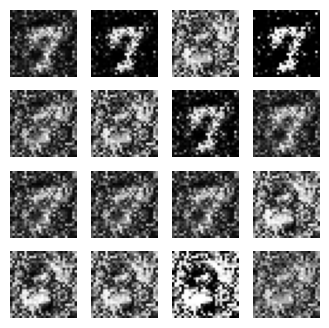

Epoch [2/10], Step [0/938], D Loss: 0.7161, G Loss: 2.5881
Epoch [2/10], Step [100/938], D Loss: 0.7113, G Loss: 1.9783
Epoch [2/10], Step [200/938], D Loss: 1.2676, G Loss: 2.8495
Epoch [2/10], Step [300/938], D Loss: 1.3402, G Loss: 3.3265
Epoch [2/10], Step [400/938], D Loss: 0.9137, G Loss: 1.7273
Epoch [2/10], Step [500/938], D Loss: 1.7287, G Loss: 1.1033
Epoch [2/10], Step [600/938], D Loss: 0.8548, G Loss: 2.5909
Epoch [2/10], Step [700/938], D Loss: 0.5698, G Loss: 2.2661
Epoch [2/10], Step [800/938], D Loss: 1.1141, G Loss: 0.8683
Epoch [2/10], Step [900/938], D Loss: 0.7344, G Loss: 1.9330


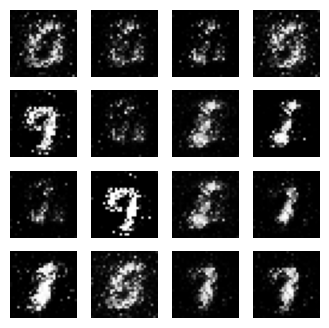

Epoch [3/10], Step [0/938], D Loss: 0.8248, G Loss: 1.1587
Epoch [3/10], Step [100/938], D Loss: 1.0133, G Loss: 2.2146
Epoch [3/10], Step [200/938], D Loss: 0.9644, G Loss: 3.1176
Epoch [3/10], Step [300/938], D Loss: 0.8210, G Loss: 1.5495
Epoch [3/10], Step [400/938], D Loss: 1.2906, G Loss: 3.1782
Epoch [3/10], Step [500/938], D Loss: 0.9284, G Loss: 1.2188
Epoch [3/10], Step [600/938], D Loss: 1.7043, G Loss: 0.7288
Epoch [3/10], Step [700/938], D Loss: 0.9084, G Loss: 1.4359
Epoch [3/10], Step [800/938], D Loss: 0.9249, G Loss: 1.1530
Epoch [3/10], Step [900/938], D Loss: 0.7536, G Loss: 1.7851


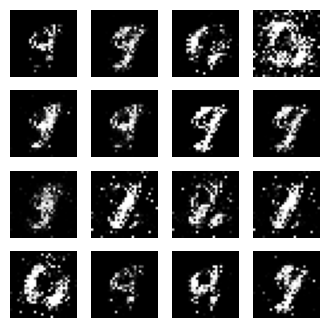

Epoch [4/10], Step [0/938], D Loss: 0.7165, G Loss: 2.7332
Epoch [4/10], Step [100/938], D Loss: 0.8275, G Loss: 2.2136
Epoch [4/10], Step [200/938], D Loss: 0.7696, G Loss: 1.5139
Epoch [4/10], Step [300/938], D Loss: 0.5992, G Loss: 2.1604
Epoch [4/10], Step [400/938], D Loss: 0.5008, G Loss: 2.2664
Epoch [4/10], Step [500/938], D Loss: 0.8565, G Loss: 1.3752
Epoch [4/10], Step [600/938], D Loss: 0.6261, G Loss: 2.4488
Epoch [4/10], Step [700/938], D Loss: 1.1978, G Loss: 3.5543
Epoch [4/10], Step [800/938], D Loss: 0.7312, G Loss: 1.4425
Epoch [4/10], Step [900/938], D Loss: 0.6681, G Loss: 1.7001


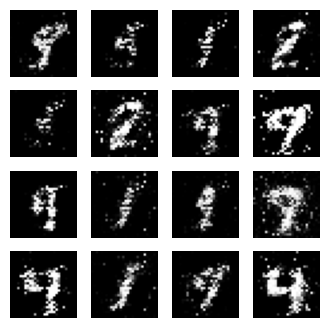

Epoch [5/10], Step [0/938], D Loss: 0.6991, G Loss: 2.5682
Epoch [5/10], Step [100/938], D Loss: 0.6934, G Loss: 1.9192
Epoch [5/10], Step [200/938], D Loss: 1.0389, G Loss: 1.3436
Epoch [5/10], Step [300/938], D Loss: 0.7315, G Loss: 2.0010
Epoch [5/10], Step [400/938], D Loss: 1.3606, G Loss: 0.5552
Epoch [5/10], Step [500/938], D Loss: 0.9295, G Loss: 2.1467
Epoch [5/10], Step [600/938], D Loss: 0.9735, G Loss: 2.4556
Epoch [5/10], Step [700/938], D Loss: 1.1624, G Loss: 0.7611
Epoch [5/10], Step [800/938], D Loss: 1.0157, G Loss: 2.7635
Epoch [5/10], Step [900/938], D Loss: 0.6554, G Loss: 1.9213


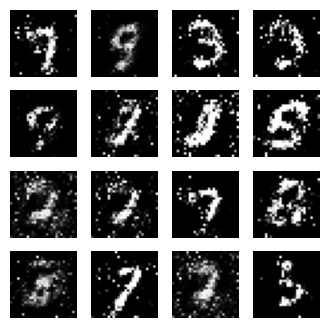

Epoch [6/10], Step [0/938], D Loss: 1.2382, G Loss: 0.6600
Epoch [6/10], Step [100/938], D Loss: 1.0187, G Loss: 2.5420
Epoch [6/10], Step [200/938], D Loss: 0.8226, G Loss: 1.2977
Epoch [6/10], Step [300/938], D Loss: 0.7957, G Loss: 1.9796
Epoch [6/10], Step [400/938], D Loss: 0.9251, G Loss: 1.0697
Epoch [6/10], Step [500/938], D Loss: 0.7303, G Loss: 1.7929
Epoch [6/10], Step [600/938], D Loss: 0.6366, G Loss: 1.6611
Epoch [6/10], Step [700/938], D Loss: 1.2228, G Loss: 2.7754
Epoch [6/10], Step [800/938], D Loss: 0.7306, G Loss: 1.9228
Epoch [6/10], Step [900/938], D Loss: 0.9062, G Loss: 1.5379


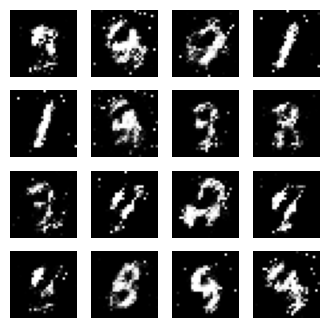

Epoch [7/10], Step [0/938], D Loss: 0.8911, G Loss: 0.8796
Epoch [7/10], Step [100/938], D Loss: 0.8061, G Loss: 1.8661
Epoch [7/10], Step [200/938], D Loss: 1.0625, G Loss: 2.5385
Epoch [7/10], Step [300/938], D Loss: 0.8373, G Loss: 1.1174
Epoch [7/10], Step [400/938], D Loss: 1.0116, G Loss: 1.9428
Epoch [7/10], Step [500/938], D Loss: 1.0467, G Loss: 1.8654
Epoch [7/10], Step [600/938], D Loss: 1.0824, G Loss: 1.5674
Epoch [7/10], Step [700/938], D Loss: 1.0263, G Loss: 1.0659
Epoch [7/10], Step [800/938], D Loss: 0.9917, G Loss: 1.2486
Epoch [7/10], Step [900/938], D Loss: 1.3022, G Loss: 0.5086


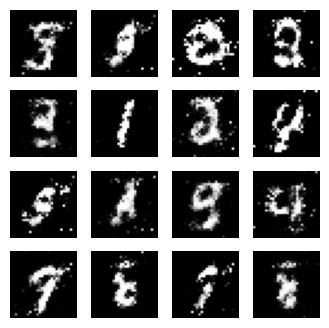

Epoch [8/10], Step [0/938], D Loss: 1.0524, G Loss: 1.8099
Epoch [8/10], Step [100/938], D Loss: 0.9350, G Loss: 1.1375
Epoch [8/10], Step [200/938], D Loss: 0.9357, G Loss: 1.2534
Epoch [8/10], Step [300/938], D Loss: 0.9803, G Loss: 1.2134
Epoch [8/10], Step [400/938], D Loss: 1.2018, G Loss: 1.6370
Epoch [8/10], Step [500/938], D Loss: 1.0844, G Loss: 1.1257
Epoch [8/10], Step [600/938], D Loss: 0.9574, G Loss: 1.4396
Epoch [8/10], Step [700/938], D Loss: 1.0079, G Loss: 1.3121
Epoch [8/10], Step [800/938], D Loss: 0.8533, G Loss: 1.9699
Epoch [8/10], Step [900/938], D Loss: 1.0075, G Loss: 1.9246


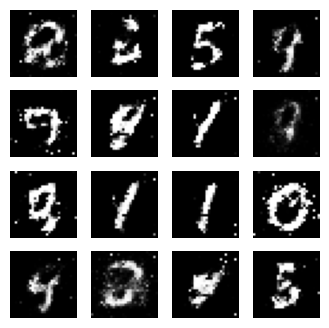

Epoch [9/10], Step [0/938], D Loss: 1.0964, G Loss: 0.8295
Epoch [9/10], Step [100/938], D Loss: 0.9988, G Loss: 1.0682
Epoch [9/10], Step [200/938], D Loss: 1.0564, G Loss: 1.5490
Epoch [9/10], Step [300/938], D Loss: 1.1287, G Loss: 1.1543
Epoch [9/10], Step [400/938], D Loss: 1.2411, G Loss: 0.8083
Epoch [9/10], Step [500/938], D Loss: 1.1041, G Loss: 1.7598
Epoch [9/10], Step [600/938], D Loss: 1.0607, G Loss: 1.4516
Epoch [9/10], Step [700/938], D Loss: 1.0044, G Loss: 1.1229
Epoch [9/10], Step [800/938], D Loss: 1.0480, G Loss: 1.0791
Epoch [9/10], Step [900/938], D Loss: 1.1581, G Loss: 1.5111


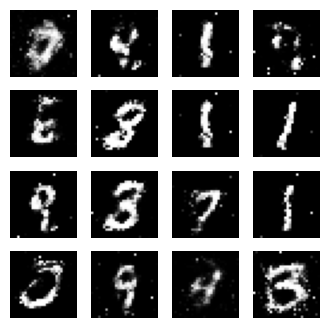

Epoch [10/10], Step [0/938], D Loss: 1.0971, G Loss: 1.0938
Epoch [10/10], Step [100/938], D Loss: 0.9544, G Loss: 1.4736
Epoch [10/10], Step [200/938], D Loss: 1.0467, G Loss: 1.0752
Epoch [10/10], Step [300/938], D Loss: 1.1556, G Loss: 1.2497
Epoch [10/10], Step [400/938], D Loss: 1.0309, G Loss: 0.9741
Epoch [10/10], Step [500/938], D Loss: 1.1903, G Loss: 0.7336
Epoch [10/10], Step [600/938], D Loss: 1.2811, G Loss: 0.7763
Epoch [10/10], Step [700/938], D Loss: 1.0541, G Loss: 1.2588
Epoch [10/10], Step [800/938], D Loss: 1.0472, G Loss: 1.4223
Epoch [10/10], Step [900/938], D Loss: 1.2469, G Loss: 1.6386


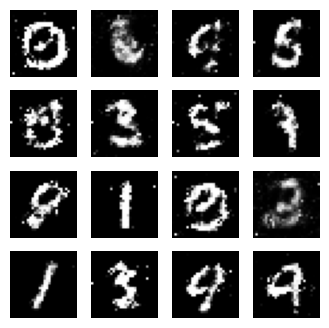

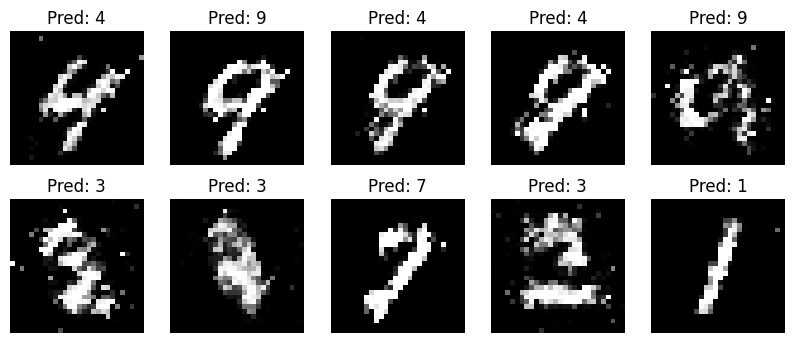

In [11]:
# Розмір вектору шуму, який подаємо на вхід Генератору
z_dim = 100

# Розмір зображення MNIST після "розгортання" в вектор
img_size = 28 * 28

optimizer_g_params = {"lr": 0.0002, "betas": (0.5, 0.999)}
optimizer_d_params = {"lr": 0.0002, "betas": (0.5, 0.999)}

generator = GANGenerator(z_dim=z_dim, img_size=img_size)
discriminator = GANDiscriminator(img_size=img_size)

# Перевіримо розмір виводу
z_sample = torch.randn(16, z_dim)
fake_images = generator(z_sample)
print("Fake images shape:", fake_images.shape)  # [16, 1, 28, 28]

validity = discriminator(fake_images)
print("Validity shape:", validity.shape)  # [16, 1]

trainer = Trainer(
    generator=generator,
    discriminator=discriminator,
    batch_size=64,
    device="cuda" if torch.cuda.is_available() else "cpu",
    optimizer_g=optim.Adam,
    optimizer_d=optim.Adam,
    optimizer_g_par=optimizer_g_params,
    optimizer_d_par=optimizer_d_params,
)

trainer.train(train_loader, 'gan', num_epochs=10)

### DCGAN (Deep Convolutional GAN)

Epoch [1/10], Step [0/938], D Loss: 1.3864, G Loss: 0.9706
Epoch [1/10], Step [100/938], D Loss: 0.8645, G Loss: 1.7667
Epoch [1/10], Step [200/938], D Loss: 1.2245, G Loss: 0.9113
Epoch [1/10], Step [300/938], D Loss: 1.0669, G Loss: 1.1213
Epoch [1/10], Step [400/938], D Loss: 0.9608, G Loss: 1.1730
Epoch [1/10], Step [500/938], D Loss: 0.8808, G Loss: 1.0894
Epoch [1/10], Step [600/938], D Loss: 0.9985, G Loss: 1.1805
Epoch [1/10], Step [700/938], D Loss: 1.0352, G Loss: 1.1015
Epoch [1/10], Step [800/938], D Loss: 1.1676, G Loss: 0.8160
Epoch [1/10], Step [900/938], D Loss: 1.1003, G Loss: 0.7431


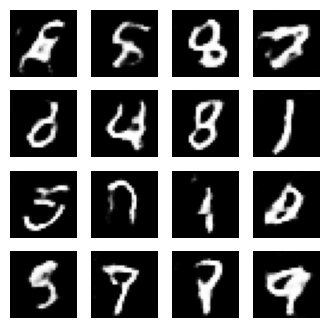

Epoch [2/10], Step [0/938], D Loss: 0.9901, G Loss: 1.2708
Epoch [2/10], Step [100/938], D Loss: 1.1624, G Loss: 1.0001
Epoch [2/10], Step [200/938], D Loss: 1.0476, G Loss: 0.9428
Epoch [2/10], Step [300/938], D Loss: 1.0986, G Loss: 1.1732
Epoch [2/10], Step [400/938], D Loss: 1.1031, G Loss: 1.9447
Epoch [2/10], Step [500/938], D Loss: 0.9482, G Loss: 1.2860
Epoch [2/10], Step [600/938], D Loss: 1.1009, G Loss: 1.4919
Epoch [2/10], Step [700/938], D Loss: 1.1533, G Loss: 0.9919
Epoch [2/10], Step [800/938], D Loss: 1.0230, G Loss: 1.1955
Epoch [2/10], Step [900/938], D Loss: 1.0952, G Loss: 1.6042


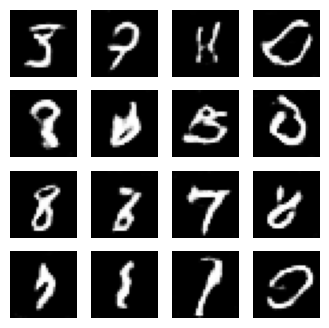

Epoch [3/10], Step [0/938], D Loss: 1.1929, G Loss: 1.6910
Epoch [3/10], Step [100/938], D Loss: 0.9387, G Loss: 1.4251
Epoch [3/10], Step [200/938], D Loss: 1.1954, G Loss: 0.6784
Epoch [3/10], Step [300/938], D Loss: 1.0653, G Loss: 0.7874
Epoch [3/10], Step [400/938], D Loss: 1.1889, G Loss: 1.2508
Epoch [3/10], Step [500/938], D Loss: 1.1838, G Loss: 0.8042
Epoch [3/10], Step [600/938], D Loss: 1.1125, G Loss: 0.9695
Epoch [3/10], Step [700/938], D Loss: 1.1453, G Loss: 1.4173
Epoch [3/10], Step [800/938], D Loss: 1.0684, G Loss: 1.1974
Epoch [3/10], Step [900/938], D Loss: 1.0344, G Loss: 1.2865


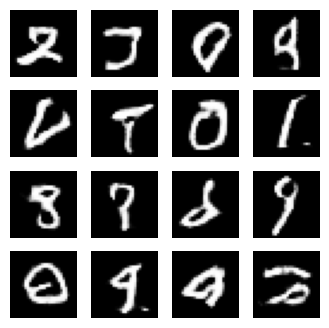

Epoch [4/10], Step [0/938], D Loss: 1.0767, G Loss: 0.7997
Epoch [4/10], Step [100/938], D Loss: 1.2289, G Loss: 0.7803
Epoch [4/10], Step [200/938], D Loss: 1.0365, G Loss: 1.3415
Epoch [4/10], Step [300/938], D Loss: 1.1077, G Loss: 1.1672
Epoch [4/10], Step [400/938], D Loss: 1.0251, G Loss: 1.1324
Epoch [4/10], Step [500/938], D Loss: 1.0995, G Loss: 1.1715
Epoch [4/10], Step [600/938], D Loss: 1.1843, G Loss: 0.7739
Epoch [4/10], Step [700/938], D Loss: 1.0946, G Loss: 1.0090
Epoch [4/10], Step [800/938], D Loss: 1.1901, G Loss: 0.8312
Epoch [4/10], Step [900/938], D Loss: 1.2318, G Loss: 1.6148


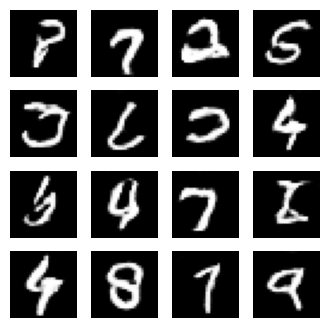

Epoch [5/10], Step [0/938], D Loss: 1.0155, G Loss: 1.2499
Epoch [5/10], Step [100/938], D Loss: 1.2774, G Loss: 0.8857
Epoch [5/10], Step [200/938], D Loss: 1.3321, G Loss: 0.7511
Epoch [5/10], Step [300/938], D Loss: 1.1315, G Loss: 0.9613
Epoch [5/10], Step [400/938], D Loss: 1.2464, G Loss: 1.1737
Epoch [5/10], Step [500/938], D Loss: 1.2191, G Loss: 1.6434
Epoch [5/10], Step [600/938], D Loss: 1.2007, G Loss: 0.8934
Epoch [5/10], Step [700/938], D Loss: 1.3076, G Loss: 1.3158
Epoch [5/10], Step [800/938], D Loss: 1.2399, G Loss: 1.0199
Epoch [5/10], Step [900/938], D Loss: 1.2347, G Loss: 1.4338


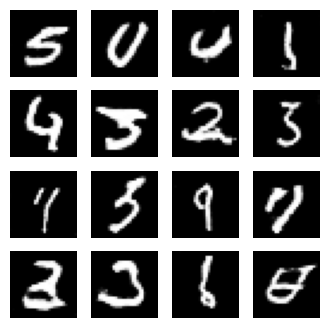

Epoch [6/10], Step [0/938], D Loss: 1.1316, G Loss: 1.2800
Epoch [6/10], Step [100/938], D Loss: 1.0876, G Loss: 0.9974
Epoch [6/10], Step [200/938], D Loss: 0.9961, G Loss: 1.1962
Epoch [6/10], Step [300/938], D Loss: 1.1911, G Loss: 1.0764
Epoch [6/10], Step [400/938], D Loss: 1.1860, G Loss: 1.3196
Epoch [6/10], Step [500/938], D Loss: 1.1314, G Loss: 1.0610
Epoch [6/10], Step [600/938], D Loss: 1.1874, G Loss: 0.7123
Epoch [6/10], Step [700/938], D Loss: 1.2370, G Loss: 1.1242
Epoch [6/10], Step [800/938], D Loss: 1.1818, G Loss: 1.0130
Epoch [6/10], Step [900/938], D Loss: 1.2366, G Loss: 1.0294


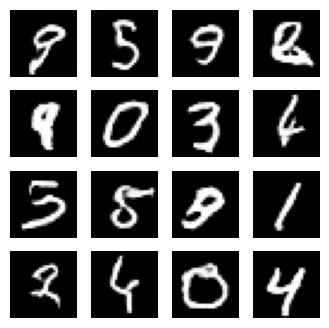

Epoch [7/10], Step [0/938], D Loss: 1.2927, G Loss: 1.4413
Epoch [7/10], Step [100/938], D Loss: 1.1666, G Loss: 0.7271
Epoch [7/10], Step [200/938], D Loss: 1.2166, G Loss: 0.9745
Epoch [7/10], Step [300/938], D Loss: 1.2491, G Loss: 1.1353
Epoch [7/10], Step [400/938], D Loss: 1.1876, G Loss: 0.9192
Epoch [7/10], Step [500/938], D Loss: 1.2878, G Loss: 1.0915
Epoch [7/10], Step [600/938], D Loss: 1.2112, G Loss: 0.9749
Epoch [7/10], Step [700/938], D Loss: 1.1253, G Loss: 1.1743
Epoch [7/10], Step [800/938], D Loss: 1.1748, G Loss: 0.7274
Epoch [7/10], Step [900/938], D Loss: 1.3395, G Loss: 1.0347


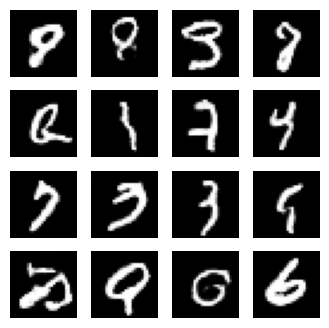

Epoch [8/10], Step [0/938], D Loss: 1.1350, G Loss: 1.2026
Epoch [8/10], Step [100/938], D Loss: 1.2791, G Loss: 1.3108
Epoch [8/10], Step [200/938], D Loss: 1.2872, G Loss: 0.7026
Epoch [8/10], Step [300/938], D Loss: 1.0711, G Loss: 1.1242
Epoch [8/10], Step [400/938], D Loss: 1.2097, G Loss: 1.0543
Epoch [8/10], Step [500/938], D Loss: 1.1716, G Loss: 0.9422
Epoch [8/10], Step [600/938], D Loss: 1.1997, G Loss: 1.1383
Epoch [8/10], Step [700/938], D Loss: 1.1097, G Loss: 1.1199
Epoch [8/10], Step [800/938], D Loss: 1.4058, G Loss: 1.1899
Epoch [8/10], Step [900/938], D Loss: 1.2724, G Loss: 1.0110


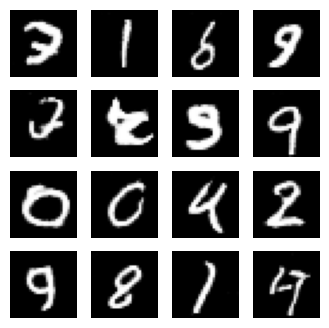

Epoch [9/10], Step [0/938], D Loss: 1.1633, G Loss: 1.2850
Epoch [9/10], Step [100/938], D Loss: 1.1765, G Loss: 0.8830
Epoch [9/10], Step [200/938], D Loss: 1.2745, G Loss: 0.9086
Epoch [9/10], Step [300/938], D Loss: 1.3141, G Loss: 1.1378
Epoch [9/10], Step [400/938], D Loss: 1.2046, G Loss: 1.1174
Epoch [9/10], Step [500/938], D Loss: 1.1781, G Loss: 0.9984
Epoch [9/10], Step [600/938], D Loss: 1.3026, G Loss: 0.8271
Epoch [9/10], Step [700/938], D Loss: 1.3268, G Loss: 1.2064
Epoch [9/10], Step [800/938], D Loss: 1.2655, G Loss: 0.9247
Epoch [9/10], Step [900/938], D Loss: 1.2550, G Loss: 0.8383


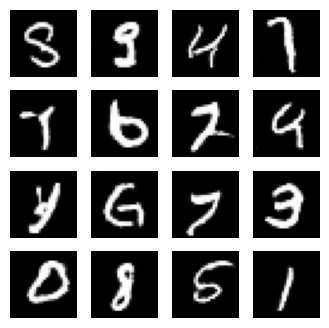

Epoch [10/10], Step [0/938], D Loss: 1.1917, G Loss: 0.8084
Epoch [10/10], Step [100/938], D Loss: 1.3097, G Loss: 0.9798
Epoch [10/10], Step [200/938], D Loss: 1.2776, G Loss: 1.0954
Epoch [10/10], Step [300/938], D Loss: 1.2711, G Loss: 1.1346
Epoch [10/10], Step [400/938], D Loss: 1.3616, G Loss: 1.0115
Epoch [10/10], Step [500/938], D Loss: 1.1673, G Loss: 0.9432
Epoch [10/10], Step [600/938], D Loss: 1.2481, G Loss: 0.8304
Epoch [10/10], Step [700/938], D Loss: 1.3016, G Loss: 0.9332
Epoch [10/10], Step [800/938], D Loss: 1.1957, G Loss: 1.0256
Epoch [10/10], Step [900/938], D Loss: 1.4147, G Loss: 0.9689


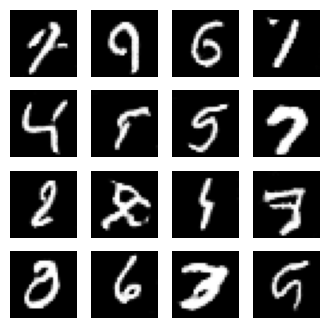

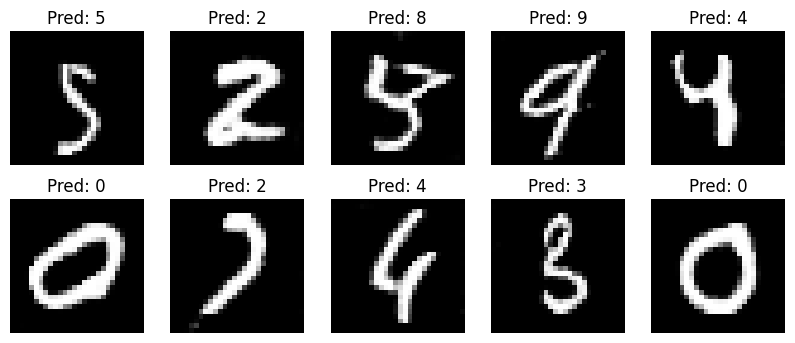

In [12]:
# Розмір вектору шуму, який подаємо на вхід Генератору
z_dim = 100

# Розмір зображення MNIST після "розгортання" в вектор
img_size = 28 * 28

optimizer_g_params = {"lr": 0.0002, "betas": (0.5, 0.999)}
optimizer_d_params = {"lr": 0.0002, "betas": (0.5, 0.999)}

generator = DCGANGenerator(z_dim=z_dim)
discriminator = DCGANDiscriminator()

trainer = Trainer(
    generator=generator,
    discriminator=discriminator,
    batch_size=64,
    device="cuda" if torch.cuda.is_available() else "cpu",
    optimizer_g=optim.Adam,
    optimizer_d=optim.Adam,
    optimizer_g_par=optimizer_g_params,
    optimizer_d_par=optimizer_d_params,
)

trainer.test_output

trainer.train(train_loader, 'gan', num_epochs=10)

### WGAN (Wasserstein GAN)

Epoch [1/10], Step [0/938], D Loss: -0.0181, G Loss: -0.0083
Epoch [1/10], Step [100/938], D Loss: -0.0154, G Loss: -0.0230
Epoch [1/10], Step [200/938], D Loss: -0.0282, G Loss: 0.0128
Epoch [1/10], Step [300/938], D Loss: -0.0625, G Loss: 0.0586
Epoch [1/10], Step [400/938], D Loss: -0.0789, G Loss: 0.0807
Epoch [1/10], Step [500/938], D Loss: -0.0943, G Loss: 0.1228
Epoch [1/10], Step [600/938], D Loss: -0.0889, G Loss: 0.1178
Epoch [1/10], Step [700/938], D Loss: -0.0853, G Loss: 0.0870
Epoch [1/10], Step [800/938], D Loss: -0.0877, G Loss: 0.0909
Epoch [1/10], Step [900/938], D Loss: -0.0883, G Loss: 0.0860


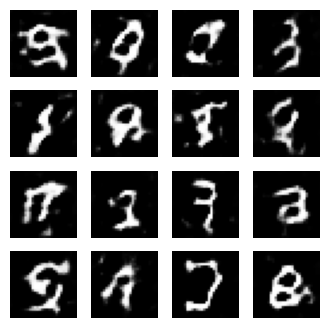

Epoch [2/10], Step [0/938], D Loss: -0.0954, G Loss: 0.0829
Epoch [2/10], Step [100/938], D Loss: -0.0713, G Loss: 0.0936
Epoch [2/10], Step [200/938], D Loss: -0.0827, G Loss: 0.0850
Epoch [2/10], Step [300/938], D Loss: -0.0890, G Loss: 0.0702
Epoch [2/10], Step [400/938], D Loss: -0.0730, G Loss: 0.0705
Epoch [2/10], Step [500/938], D Loss: -0.0587, G Loss: 0.0532
Epoch [2/10], Step [600/938], D Loss: -0.0514, G Loss: 0.0884
Epoch [2/10], Step [700/938], D Loss: -0.0497, G Loss: 0.0699
Epoch [2/10], Step [800/938], D Loss: -0.0471, G Loss: 0.0640
Epoch [2/10], Step [900/938], D Loss: -0.0470, G Loss: 0.0683


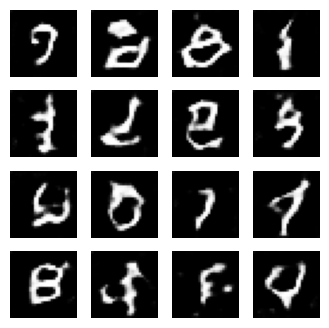

Epoch [3/10], Step [0/938], D Loss: -0.0436, G Loss: 0.0358
Epoch [3/10], Step [100/938], D Loss: -0.0382, G Loss: 0.0557
Epoch [3/10], Step [200/938], D Loss: -0.0684, G Loss: 0.0390
Epoch [3/10], Step [300/938], D Loss: -0.0518, G Loss: 0.0455
Epoch [3/10], Step [400/938], D Loss: -0.0554, G Loss: 0.0143
Epoch [3/10], Step [500/938], D Loss: -0.0889, G Loss: 0.0444
Epoch [3/10], Step [600/938], D Loss: -0.0481, G Loss: 0.0263
Epoch [3/10], Step [700/938], D Loss: -0.0434, G Loss: 0.0627
Epoch [3/10], Step [800/938], D Loss: -0.0582, G Loss: 0.0037
Epoch [3/10], Step [900/938], D Loss: -0.0434, G Loss: 0.0377


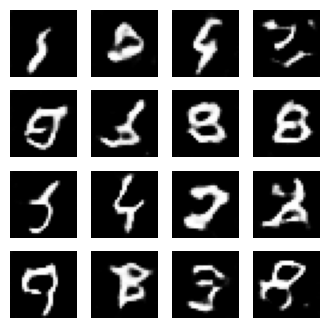

Epoch [4/10], Step [0/938], D Loss: -0.0332, G Loss: 0.0244
Epoch [4/10], Step [100/938], D Loss: -0.0398, G Loss: 0.0284
Epoch [4/10], Step [200/938], D Loss: -0.0406, G Loss: 0.0421
Epoch [4/10], Step [300/938], D Loss: -0.0392, G Loss: 0.1135
Epoch [4/10], Step [400/938], D Loss: -0.0368, G Loss: 0.0559
Epoch [4/10], Step [500/938], D Loss: -0.0391, G Loss: 0.0103
Epoch [4/10], Step [600/938], D Loss: -0.0401, G Loss: 0.0367
Epoch [4/10], Step [700/938], D Loss: -0.0428, G Loss: 0.0570
Epoch [4/10], Step [800/938], D Loss: -0.0434, G Loss: -0.0075
Epoch [4/10], Step [900/938], D Loss: -0.0414, G Loss: 0.1021


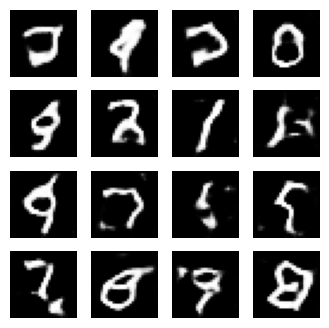

Epoch [5/10], Step [0/938], D Loss: -0.0309, G Loss: 0.0839
Epoch [5/10], Step [100/938], D Loss: -0.0475, G Loss: 0.0670
Epoch [5/10], Step [200/938], D Loss: -0.0316, G Loss: 0.1042
Epoch [5/10], Step [300/938], D Loss: -0.0374, G Loss: 0.0247
Epoch [5/10], Step [400/938], D Loss: -0.0302, G Loss: 0.0806
Epoch [5/10], Step [500/938], D Loss: -0.0364, G Loss: 0.0860
Epoch [5/10], Step [600/938], D Loss: -0.0499, G Loss: 0.0791
Epoch [5/10], Step [700/938], D Loss: -0.0327, G Loss: 0.1176
Epoch [5/10], Step [800/938], D Loss: -0.0413, G Loss: 0.0176
Epoch [5/10], Step [900/938], D Loss: -0.0338, G Loss: 0.0454


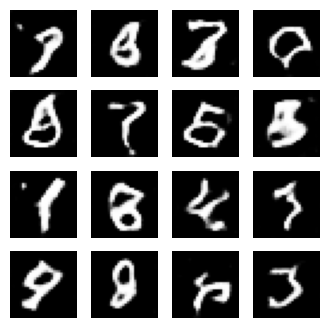

Epoch [6/10], Step [0/938], D Loss: -0.0376, G Loss: 0.1511
Epoch [6/10], Step [100/938], D Loss: -0.0579, G Loss: 0.0076
Epoch [6/10], Step [200/938], D Loss: -0.0384, G Loss: 0.0418
Epoch [6/10], Step [300/938], D Loss: -0.0384, G Loss: 0.0537
Epoch [6/10], Step [400/938], D Loss: -0.0264, G Loss: 0.0606
Epoch [6/10], Step [500/938], D Loss: -0.0348, G Loss: 0.0926
Epoch [6/10], Step [600/938], D Loss: -0.0219, G Loss: 0.0290
Epoch [6/10], Step [700/938], D Loss: -0.0324, G Loss: -0.0051
Epoch [6/10], Step [800/938], D Loss: -0.0328, G Loss: 0.1248
Epoch [6/10], Step [900/938], D Loss: -0.0318, G Loss: 0.0599


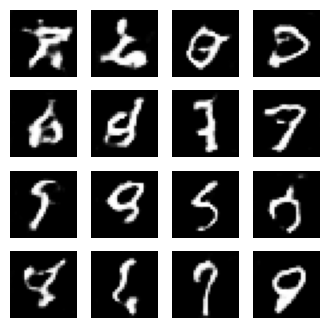

Epoch [7/10], Step [0/938], D Loss: -0.0247, G Loss: -0.0245
Epoch [7/10], Step [100/938], D Loss: -0.0468, G Loss: 0.0780
Epoch [7/10], Step [200/938], D Loss: -0.0316, G Loss: 0.0379
Epoch [7/10], Step [300/938], D Loss: -0.0293, G Loss: 0.0684
Epoch [7/10], Step [400/938], D Loss: -0.0240, G Loss: 0.0315
Epoch [7/10], Step [500/938], D Loss: -0.0293, G Loss: 0.1115
Epoch [7/10], Step [600/938], D Loss: -0.0315, G Loss: 0.0533
Epoch [7/10], Step [700/938], D Loss: -0.0364, G Loss: 0.0463
Epoch [7/10], Step [800/938], D Loss: -0.0333, G Loss: 0.0514
Epoch [7/10], Step [900/938], D Loss: -0.0418, G Loss: 0.0788


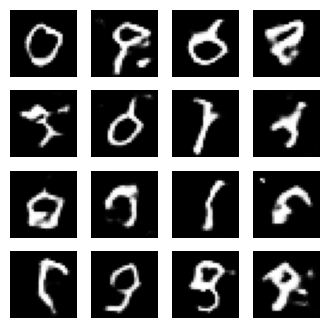

Epoch [8/10], Step [0/938], D Loss: -0.0502, G Loss: -0.0215
Epoch [8/10], Step [100/938], D Loss: -0.0355, G Loss: 0.0350
Epoch [8/10], Step [200/938], D Loss: -0.0309, G Loss: 0.0579
Epoch [8/10], Step [300/938], D Loss: -0.0321, G Loss: 0.0328
Epoch [8/10], Step [400/938], D Loss: -0.0375, G Loss: 0.1435
Epoch [8/10], Step [500/938], D Loss: -0.0268, G Loss: 0.1233
Epoch [8/10], Step [600/938], D Loss: -0.0342, G Loss: 0.0149
Epoch [8/10], Step [700/938], D Loss: -0.0292, G Loss: 0.0147
Epoch [8/10], Step [800/938], D Loss: -0.0269, G Loss: 0.1226
Epoch [8/10], Step [900/938], D Loss: -0.0275, G Loss: 0.0080


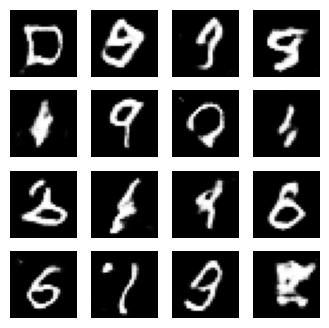

Epoch [9/10], Step [0/938], D Loss: -0.0301, G Loss: 0.0144
Epoch [9/10], Step [100/938], D Loss: -0.0234, G Loss: 0.1428
Epoch [9/10], Step [200/938], D Loss: -0.0243, G Loss: 0.0327
Epoch [9/10], Step [300/938], D Loss: -0.0513, G Loss: -0.0177
Epoch [9/10], Step [400/938], D Loss: -0.0275, G Loss: 0.0972
Epoch [9/10], Step [500/938], D Loss: -0.0311, G Loss: -0.0154
Epoch [9/10], Step [600/938], D Loss: -0.0253, G Loss: 0.0834
Epoch [9/10], Step [700/938], D Loss: -0.0349, G Loss: 0.0244
Epoch [9/10], Step [800/938], D Loss: -0.0314, G Loss: 0.0989
Epoch [9/10], Step [900/938], D Loss: -0.0365, G Loss: 0.1451


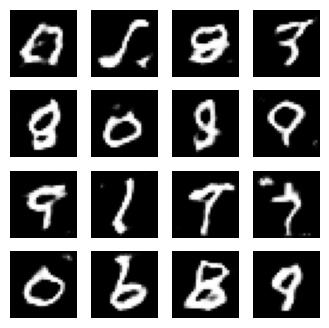

Epoch [10/10], Step [0/938], D Loss: -0.0484, G Loss: 0.0250
Epoch [10/10], Step [100/938], D Loss: -0.0343, G Loss: 0.0440
Epoch [10/10], Step [200/938], D Loss: -0.0325, G Loss: -0.0076
Epoch [10/10], Step [300/938], D Loss: -0.0275, G Loss: 0.0041
Epoch [10/10], Step [400/938], D Loss: -0.0321, G Loss: -0.0623
Epoch [10/10], Step [500/938], D Loss: -0.0271, G Loss: 0.0722
Epoch [10/10], Step [600/938], D Loss: -0.0430, G Loss: -0.0635
Epoch [10/10], Step [700/938], D Loss: -0.0356, G Loss: 0.0002
Epoch [10/10], Step [800/938], D Loss: -0.0168, G Loss: 0.0110
Epoch [10/10], Step [900/938], D Loss: -0.0344, G Loss: 0.0886


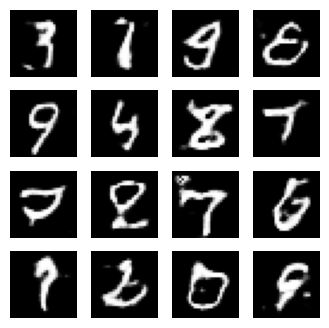

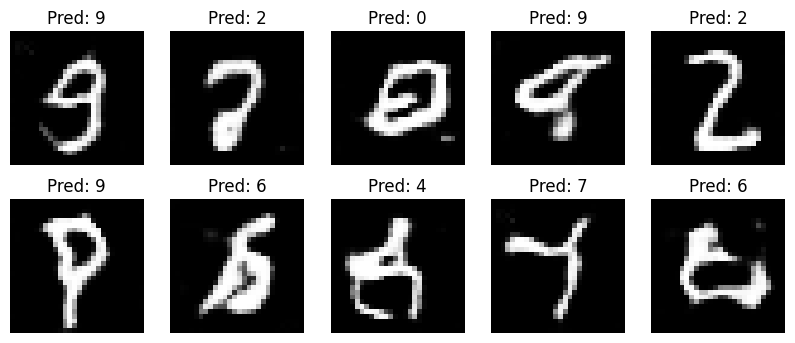

In [13]:

z_dim = 100
generator = WGANGenerator(z_dim=z_dim)
critic = WGANCritic()

optimizer_par = {"lr": 0.00005}

trainer = Trainer(
    generator=generator,
    discriminator=critic,
    batch_size=64,
    device="cuda" if torch.cuda.is_available() else "cpu",
    optimizer_g=optim.RMSprop,
    optimizer_d=optim.RMSprop,
    optimizer_g_par=optimizer_par,
    optimizer_d_par=optimizer_par,
)

trainer.train(train_loader, 'wgan', num_epochs=10)


### cGAN (Conditional GAN) 

Epoch [1/10], Step [0/938], D Loss: 1.4640, G Loss: 0.9821
Epoch [1/10], Step [100/938], D Loss: 1.3455, G Loss: 0.7366
Epoch [1/10], Step [200/938], D Loss: 1.4090, G Loss: 0.6958
Epoch [1/10], Step [300/938], D Loss: 1.4121, G Loss: 0.6579
Epoch [1/10], Step [400/938], D Loss: 1.3801, G Loss: 0.6848
Epoch [1/10], Step [500/938], D Loss: 1.3088, G Loss: 0.7825
Epoch [1/10], Step [600/938], D Loss: 1.3654, G Loss: 0.7102
Epoch [1/10], Step [700/938], D Loss: 1.3544, G Loss: 0.6925
Epoch [1/10], Step [800/938], D Loss: 1.4143, G Loss: 0.6476
Epoch [1/10], Step [900/938], D Loss: 1.3732, G Loss: 0.7233


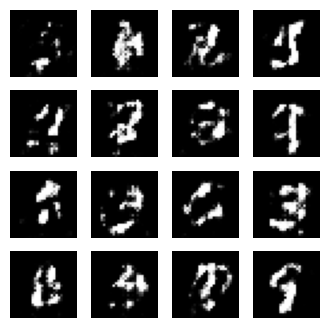

Epoch [2/10], Step [0/938], D Loss: 1.2154, G Loss: 0.8174
Epoch [2/10], Step [100/938], D Loss: 1.4798, G Loss: 0.6131
Epoch [2/10], Step [200/938], D Loss: 1.4494, G Loss: 0.7390
Epoch [2/10], Step [300/938], D Loss: 1.2287, G Loss: 0.8305
Epoch [2/10], Step [400/938], D Loss: 1.4419, G Loss: 0.6195
Epoch [2/10], Step [500/938], D Loss: 1.4304, G Loss: 0.6381
Epoch [2/10], Step [600/938], D Loss: 1.3545, G Loss: 0.8703
Epoch [2/10], Step [700/938], D Loss: 1.4228, G Loss: 0.7219
Epoch [2/10], Step [800/938], D Loss: 1.2062, G Loss: 0.8974
Epoch [2/10], Step [900/938], D Loss: 1.2816, G Loss: 0.7414


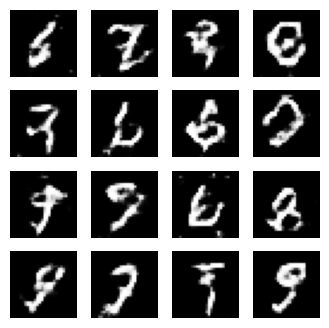

Epoch [3/10], Step [0/938], D Loss: 1.3371, G Loss: 0.8093
Epoch [3/10], Step [100/938], D Loss: 1.4638, G Loss: 0.6634
Epoch [3/10], Step [200/938], D Loss: 1.5213, G Loss: 0.7762
Epoch [3/10], Step [300/938], D Loss: 1.4115, G Loss: 0.7228
Epoch [3/10], Step [400/938], D Loss: 1.3957, G Loss: 0.8181
Epoch [3/10], Step [500/938], D Loss: 1.3140, G Loss: 0.7652
Epoch [3/10], Step [600/938], D Loss: 1.2573, G Loss: 0.8306
Epoch [3/10], Step [700/938], D Loss: 1.2443, G Loss: 0.8697
Epoch [3/10], Step [800/938], D Loss: 1.3160, G Loss: 0.7559
Epoch [3/10], Step [900/938], D Loss: 1.3328, G Loss: 0.7095


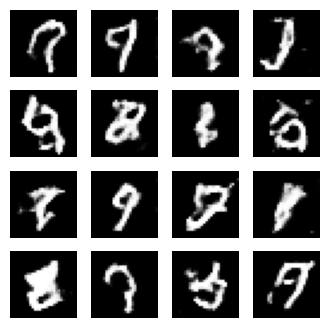

Epoch [4/10], Step [0/938], D Loss: 1.1777, G Loss: 0.9036
Epoch [4/10], Step [100/938], D Loss: 1.1734, G Loss: 0.8639
Epoch [4/10], Step [200/938], D Loss: 1.2278, G Loss: 0.8290
Epoch [4/10], Step [300/938], D Loss: 1.4412, G Loss: 0.7134
Epoch [4/10], Step [400/938], D Loss: 1.3566, G Loss: 0.7574
Epoch [4/10], Step [500/938], D Loss: 1.4141, G Loss: 0.7274
Epoch [4/10], Step [600/938], D Loss: 1.3473, G Loss: 0.8361
Epoch [4/10], Step [700/938], D Loss: 1.4101, G Loss: 0.7229
Epoch [4/10], Step [800/938], D Loss: 1.3691, G Loss: 0.7238
Epoch [4/10], Step [900/938], D Loss: 1.2402, G Loss: 0.8613


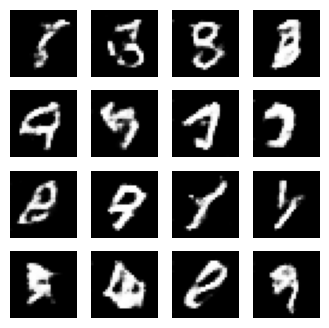

Epoch [5/10], Step [0/938], D Loss: 1.4496, G Loss: 0.7335
Epoch [5/10], Step [100/938], D Loss: 1.1957, G Loss: 0.8879
Epoch [5/10], Step [200/938], D Loss: 1.0592, G Loss: 0.8846
Epoch [5/10], Step [300/938], D Loss: 1.5346, G Loss: 0.5943
Epoch [5/10], Step [400/938], D Loss: 1.2077, G Loss: 0.8115
Epoch [5/10], Step [500/938], D Loss: 1.2441, G Loss: 0.7951
Epoch [5/10], Step [600/938], D Loss: 1.1572, G Loss: 0.8970
Epoch [5/10], Step [700/938], D Loss: 1.2760, G Loss: 0.8084
Epoch [5/10], Step [800/938], D Loss: 1.2416, G Loss: 0.8255
Epoch [5/10], Step [900/938], D Loss: 1.4578, G Loss: 0.6833


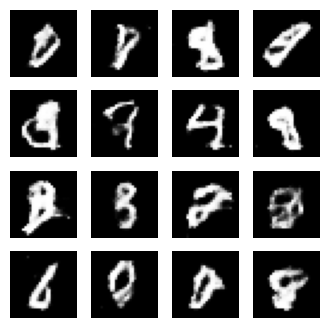

Epoch [6/10], Step [0/938], D Loss: 1.2525, G Loss: 0.7729
Epoch [6/10], Step [100/938], D Loss: 1.3469, G Loss: 0.7287
Epoch [6/10], Step [200/938], D Loss: 1.5042, G Loss: 0.6643
Epoch [6/10], Step [300/938], D Loss: 1.3755, G Loss: 0.8154
Epoch [6/10], Step [400/938], D Loss: 1.3530, G Loss: 0.6320
Epoch [6/10], Step [500/938], D Loss: 1.5295, G Loss: 0.6448
Epoch [6/10], Step [600/938], D Loss: 1.3322, G Loss: 0.6647
Epoch [6/10], Step [700/938], D Loss: 1.3023, G Loss: 0.8151
Epoch [6/10], Step [800/938], D Loss: 1.6241, G Loss: 0.6689
Epoch [6/10], Step [900/938], D Loss: 1.3557, G Loss: 0.7512


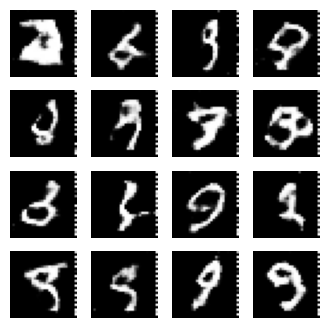

Epoch [7/10], Step [0/938], D Loss: 1.4999, G Loss: 0.6752
Epoch [7/10], Step [100/938], D Loss: 1.2957, G Loss: 0.8027
Epoch [7/10], Step [200/938], D Loss: 1.5110, G Loss: 0.6486
Epoch [7/10], Step [300/938], D Loss: 1.3042, G Loss: 0.7747
Epoch [7/10], Step [400/938], D Loss: 1.4172, G Loss: 0.7055
Epoch [7/10], Step [500/938], D Loss: 1.2566, G Loss: 0.7225
Epoch [7/10], Step [600/938], D Loss: 1.4774, G Loss: 0.6638
Epoch [7/10], Step [700/938], D Loss: 1.3788, G Loss: 0.7672
Epoch [7/10], Step [800/938], D Loss: 1.1915, G Loss: 0.8576
Epoch [7/10], Step [900/938], D Loss: 1.6680, G Loss: 0.6030


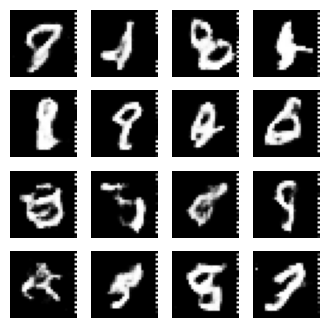

Epoch [8/10], Step [0/938], D Loss: 1.1373, G Loss: 0.8822
Epoch [8/10], Step [100/938], D Loss: 1.3067, G Loss: 0.7671
Epoch [8/10], Step [200/938], D Loss: 1.3686, G Loss: 0.8312
Epoch [8/10], Step [300/938], D Loss: 1.2679, G Loss: 0.8439
Epoch [8/10], Step [400/938], D Loss: 1.3851, G Loss: 0.6825
Epoch [8/10], Step [500/938], D Loss: 1.3544, G Loss: 0.7136
Epoch [8/10], Step [600/938], D Loss: 1.4232, G Loss: 0.6657
Epoch [8/10], Step [700/938], D Loss: 1.7548, G Loss: 0.6663
Epoch [8/10], Step [800/938], D Loss: 1.1579, G Loss: 0.8732
Epoch [8/10], Step [900/938], D Loss: 1.1934, G Loss: 0.7988


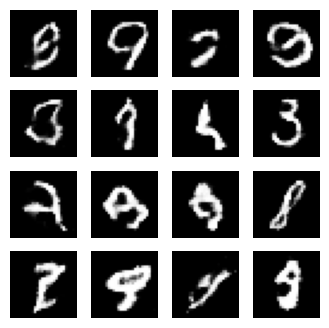

Epoch [9/10], Step [0/938], D Loss: 1.3447, G Loss: 0.7736
Epoch [9/10], Step [100/938], D Loss: 1.5475, G Loss: 0.5854
Epoch [9/10], Step [200/938], D Loss: 1.3076, G Loss: 0.7466
Epoch [9/10], Step [300/938], D Loss: 1.2801, G Loss: 0.8650
Epoch [9/10], Step [400/938], D Loss: 1.6248, G Loss: 0.6468
Epoch [9/10], Step [500/938], D Loss: 1.2515, G Loss: 0.7647
Epoch [9/10], Step [600/938], D Loss: 1.5861, G Loss: 0.6492
Epoch [9/10], Step [700/938], D Loss: 1.5338, G Loss: 0.6459
Epoch [9/10], Step [800/938], D Loss: 1.4644, G Loss: 0.6764
Epoch [9/10], Step [900/938], D Loss: 1.5125, G Loss: 0.6629


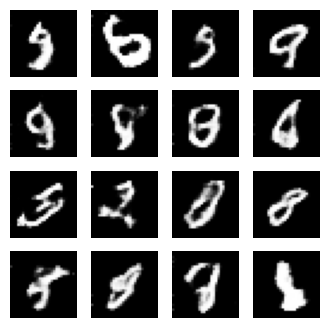

Epoch [10/10], Step [0/938], D Loss: 1.5727, G Loss: 0.5853
Epoch [10/10], Step [100/938], D Loss: 1.4069, G Loss: 0.7206
Epoch [10/10], Step [200/938], D Loss: 1.3773, G Loss: 0.7593
Epoch [10/10], Step [300/938], D Loss: 1.2908, G Loss: 0.8289
Epoch [10/10], Step [400/938], D Loss: 1.2907, G Loss: 0.8316
Epoch [10/10], Step [500/938], D Loss: 1.5612, G Loss: 0.6399
Epoch [10/10], Step [600/938], D Loss: 1.4666, G Loss: 0.7410
Epoch [10/10], Step [700/938], D Loss: 1.2677, G Loss: 0.7375
Epoch [10/10], Step [800/938], D Loss: 1.3057, G Loss: 0.7486
Epoch [10/10], Step [900/938], D Loss: 1.2550, G Loss: 0.7921


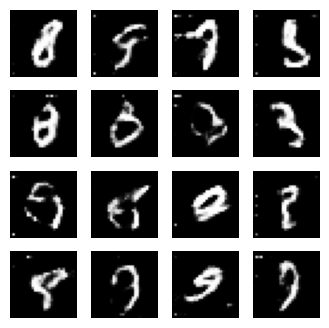

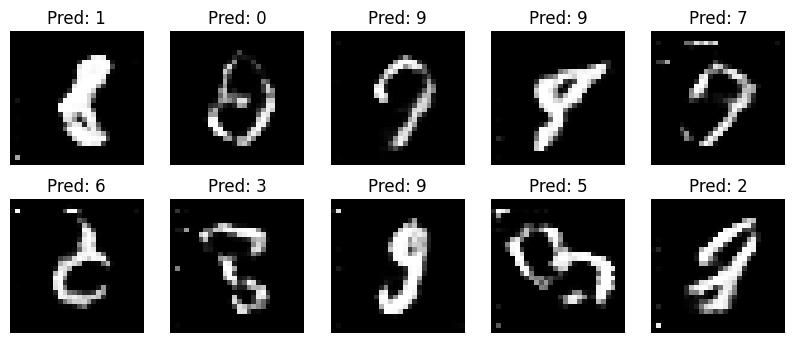

In [14]:

z_dim = 100
generator = CGANGenerator(z_dim=z_dim)
discriminator = CGANDiscriminator()

optimizer_g_params = {"lr": 0.0002, "betas": (0.5, 0.999)}
optimizer_d_params = {"lr": 0.0002, "betas": (0.5, 0.999)}

trainer = Trainer(
    generator=generator,
    discriminator=discriminator,
    batch_size=64,
    device="cuda" if torch.cuda.is_available() else "cpu",
    optimizer_g=optim.Adam,
    optimizer_d=optim.Adam,
    optimizer_g_par=optimizer_g_params,
    optimizer_d_par=optimizer_d_params,
)

trainer.train(train_loader, 'cgan', num_epochs=10)


## Fine-tuning

### DCGAN (Deep Convolutional GAN)



#### Розмір батчу: Спробуйте різні розміри батчу для кращої стабільності навчання.


##### batch_size=128

Epoch [1/10], Step [0/938], D Loss: 1.6004, G Loss: 1.0055
Epoch [1/10], Step [100/938], D Loss: 0.7100, G Loss: 1.8211
Epoch [1/10], Step [200/938], D Loss: 1.2289, G Loss: 0.8474
Epoch [1/10], Step [300/938], D Loss: 1.0637, G Loss: 1.0092
Epoch [1/10], Step [400/938], D Loss: 0.8904, G Loss: 1.0082
Epoch [1/10], Step [500/938], D Loss: 0.8291, G Loss: 1.2953
Epoch [1/10], Step [600/938], D Loss: 1.0205, G Loss: 1.0762
Epoch [1/10], Step [700/938], D Loss: 1.0362, G Loss: 0.9633
Epoch [1/10], Step [800/938], D Loss: 0.9672, G Loss: 1.0163
Epoch [1/10], Step [900/938], D Loss: 0.9826, G Loss: 1.1336


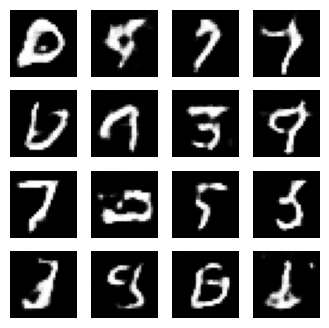

Epoch [2/10], Step [0/938], D Loss: 1.1864, G Loss: 0.7994
Epoch [2/10], Step [100/938], D Loss: 1.0696, G Loss: 1.3369
Epoch [2/10], Step [200/938], D Loss: 1.0591, G Loss: 0.7411
Epoch [2/10], Step [300/938], D Loss: 1.0096, G Loss: 1.2374
Epoch [2/10], Step [400/938], D Loss: 1.0193, G Loss: 1.2521
Epoch [2/10], Step [500/938], D Loss: 1.1902, G Loss: 1.4046
Epoch [2/10], Step [600/938], D Loss: 1.1066, G Loss: 1.3220
Epoch [2/10], Step [700/938], D Loss: 1.1680, G Loss: 1.4559
Epoch [2/10], Step [800/938], D Loss: 1.1434, G Loss: 0.8179
Epoch [2/10], Step [900/938], D Loss: 0.9612, G Loss: 1.1958


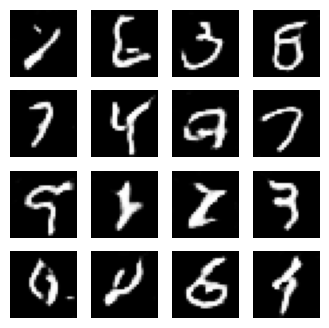

Epoch [3/10], Step [0/938], D Loss: 1.0088, G Loss: 1.4884
Epoch [3/10], Step [100/938], D Loss: 1.0875, G Loss: 0.9773
Epoch [3/10], Step [200/938], D Loss: 1.1235, G Loss: 0.9756
Epoch [3/10], Step [300/938], D Loss: 1.0522, G Loss: 1.1530
Epoch [3/10], Step [400/938], D Loss: 1.1008, G Loss: 0.8792
Epoch [3/10], Step [500/938], D Loss: 1.1629, G Loss: 0.8918
Epoch [3/10], Step [600/938], D Loss: 1.0365, G Loss: 0.9947
Epoch [3/10], Step [700/938], D Loss: 1.2128, G Loss: 0.5986
Epoch [3/10], Step [800/938], D Loss: 1.0704, G Loss: 1.0318
Epoch [3/10], Step [900/938], D Loss: 1.0450, G Loss: 0.8993


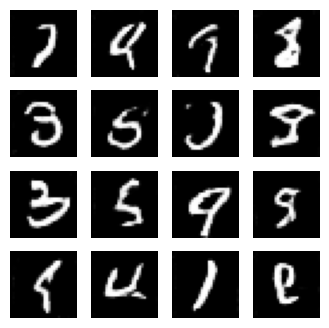

Epoch [4/10], Step [0/938], D Loss: 1.0319, G Loss: 1.1023
Epoch [4/10], Step [100/938], D Loss: 1.0817, G Loss: 1.1765
Epoch [4/10], Step [200/938], D Loss: 1.0066, G Loss: 1.3849
Epoch [4/10], Step [300/938], D Loss: 1.1748, G Loss: 1.3259
Epoch [4/10], Step [400/938], D Loss: 1.2554, G Loss: 1.1174
Epoch [4/10], Step [500/938], D Loss: 1.0155, G Loss: 1.1241
Epoch [4/10], Step [600/938], D Loss: 0.9663, G Loss: 1.0089
Epoch [4/10], Step [700/938], D Loss: 1.1244, G Loss: 0.9898
Epoch [4/10], Step [800/938], D Loss: 1.1212, G Loss: 0.9651
Epoch [4/10], Step [900/938], D Loss: 1.0729, G Loss: 0.8744


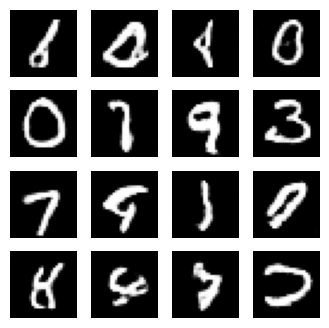

Epoch [5/10], Step [0/938], D Loss: 1.1215, G Loss: 0.7917
Epoch [5/10], Step [100/938], D Loss: 1.1924, G Loss: 0.7709
Epoch [5/10], Step [200/938], D Loss: 1.1886, G Loss: 0.8110
Epoch [5/10], Step [300/938], D Loss: 1.0950, G Loss: 1.0812
Epoch [5/10], Step [400/938], D Loss: 1.2376, G Loss: 1.0116
Epoch [5/10], Step [500/938], D Loss: 1.1411, G Loss: 1.0521
Epoch [5/10], Step [600/938], D Loss: 1.1944, G Loss: 0.9353
Epoch [5/10], Step [700/938], D Loss: 1.1305, G Loss: 0.9303
Epoch [5/10], Step [800/938], D Loss: 1.1536, G Loss: 1.0602
Epoch [5/10], Step [900/938], D Loss: 1.1280, G Loss: 1.1296


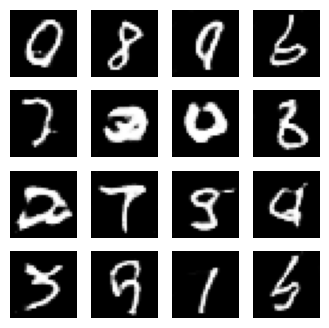

Epoch [6/10], Step [0/938], D Loss: 1.2376, G Loss: 1.3859
Epoch [6/10], Step [100/938], D Loss: 1.0567, G Loss: 1.4449
Epoch [6/10], Step [200/938], D Loss: 1.3647, G Loss: 0.6468
Epoch [6/10], Step [300/938], D Loss: 1.1500, G Loss: 1.0947
Epoch [6/10], Step [400/938], D Loss: 1.0654, G Loss: 1.1740
Epoch [6/10], Step [500/938], D Loss: 1.0652, G Loss: 1.1217
Epoch [6/10], Step [600/938], D Loss: 1.2471, G Loss: 1.0430
Epoch [6/10], Step [700/938], D Loss: 1.1703, G Loss: 0.9413
Epoch [6/10], Step [800/938], D Loss: 1.1919, G Loss: 1.0487
Epoch [6/10], Step [900/938], D Loss: 1.1946, G Loss: 0.9217


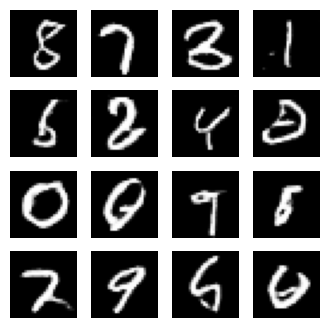

Epoch [7/10], Step [0/938], D Loss: 1.2221, G Loss: 0.7292
Epoch [7/10], Step [100/938], D Loss: 1.2170, G Loss: 1.2568
Epoch [7/10], Step [200/938], D Loss: 1.1636, G Loss: 0.8476
Epoch [7/10], Step [300/938], D Loss: 1.1455, G Loss: 1.1921
Epoch [7/10], Step [400/938], D Loss: 1.1806, G Loss: 1.4736
Epoch [7/10], Step [500/938], D Loss: 1.1700, G Loss: 0.9598
Epoch [7/10], Step [600/938], D Loss: 1.3475, G Loss: 0.5801
Epoch [7/10], Step [700/938], D Loss: 1.2985, G Loss: 1.0995
Epoch [7/10], Step [800/938], D Loss: 1.1516, G Loss: 1.3854
Epoch [7/10], Step [900/938], D Loss: 1.1448, G Loss: 0.8965


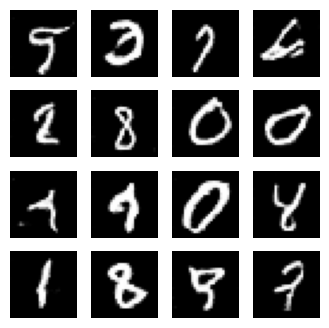

Epoch [8/10], Step [0/938], D Loss: 1.1858, G Loss: 1.0041
Epoch [8/10], Step [100/938], D Loss: 1.2352, G Loss: 1.0688
Epoch [8/10], Step [200/938], D Loss: 1.1696, G Loss: 1.0496
Epoch [8/10], Step [300/938], D Loss: 1.2480, G Loss: 0.8458
Epoch [8/10], Step [400/938], D Loss: 1.3607, G Loss: 1.0771
Epoch [8/10], Step [500/938], D Loss: 1.2576, G Loss: 0.9906
Epoch [8/10], Step [600/938], D Loss: 1.1949, G Loss: 1.2349
Epoch [8/10], Step [700/938], D Loss: 1.2488, G Loss: 0.9829
Epoch [8/10], Step [800/938], D Loss: 1.1905, G Loss: 1.0147
Epoch [8/10], Step [900/938], D Loss: 1.1744, G Loss: 0.9775


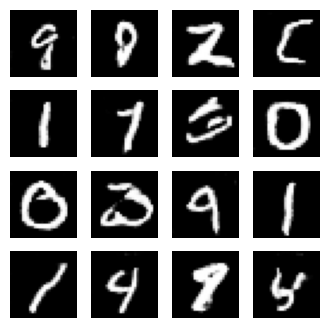

Epoch [9/10], Step [0/938], D Loss: 1.3514, G Loss: 1.2110
Epoch [9/10], Step [100/938], D Loss: 1.2906, G Loss: 0.8526
Epoch [9/10], Step [200/938], D Loss: 1.2145, G Loss: 1.1837
Epoch [9/10], Step [300/938], D Loss: 1.3279, G Loss: 0.9813
Epoch [9/10], Step [400/938], D Loss: 1.3322, G Loss: 1.1166
Epoch [9/10], Step [500/938], D Loss: 1.1689, G Loss: 0.9543
Epoch [9/10], Step [600/938], D Loss: 1.2839, G Loss: 0.8865
Epoch [9/10], Step [700/938], D Loss: 1.2290, G Loss: 0.8847
Epoch [9/10], Step [800/938], D Loss: 1.2014, G Loss: 0.9757
Epoch [9/10], Step [900/938], D Loss: 1.2630, G Loss: 0.9495


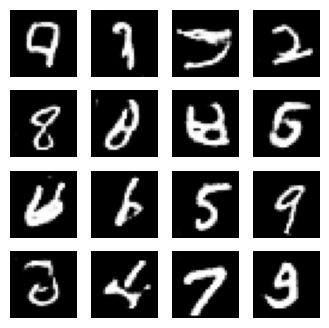

Epoch [10/10], Step [0/938], D Loss: 1.2344, G Loss: 0.9503
Epoch [10/10], Step [100/938], D Loss: 1.1301, G Loss: 1.0055
Epoch [10/10], Step [200/938], D Loss: 1.4073, G Loss: 0.6761
Epoch [10/10], Step [300/938], D Loss: 1.2289, G Loss: 0.9664
Epoch [10/10], Step [400/938], D Loss: 1.3048, G Loss: 1.0212
Epoch [10/10], Step [500/938], D Loss: 1.2851, G Loss: 0.8282
Epoch [10/10], Step [600/938], D Loss: 1.3539, G Loss: 1.0212
Epoch [10/10], Step [700/938], D Loss: 1.1717, G Loss: 0.9164
Epoch [10/10], Step [800/938], D Loss: 1.2811, G Loss: 0.8959
Epoch [10/10], Step [900/938], D Loss: 1.2260, G Loss: 1.0408


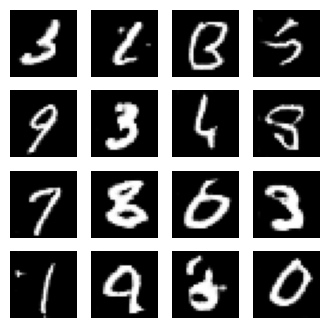

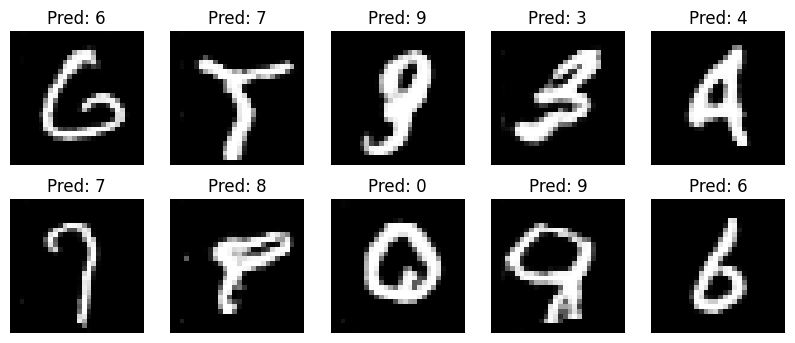

In [15]:
# Розмір вектору шуму, який подаємо на вхід Генератору
z_dim = 100

# Розмір зображення MNIST після "розгортання" в вектор
img_size = 28 * 28

optimizer_g_params = {"lr": 0.0002, "betas": (0.5, 0.999)}
optimizer_d_params = {"lr": 0.0002, "betas": (0.5, 0.999)}

generator = DCGANGenerator(z_dim=z_dim)
discriminator = DCGANDiscriminator()

trainer = Trainer(
    generator=generator,
    discriminator=discriminator,
    batch_size=128,
    device="cuda" if torch.cuda.is_available() else "cpu",
    optimizer_g=optim.Adam,
    optimizer_d=optim.Adam,
    optimizer_g_par=optimizer_g_params,
    optimizer_d_par=optimizer_d_params,
)

trainer.test_output

trainer.train(train_loader, 'gan', num_epochs=10)

##### batch_size=32

Epoch [1/10], Step [0/938], D Loss: 1.3472, G Loss: 0.9941
Epoch [1/10], Step [100/938], D Loss: 0.9702, G Loss: 1.4788
Epoch [1/10], Step [200/938], D Loss: 1.2294, G Loss: 0.8070
Epoch [1/10], Step [300/938], D Loss: 0.9131, G Loss: 1.0428
Epoch [1/10], Step [400/938], D Loss: 0.9818, G Loss: 0.7867
Epoch [1/10], Step [500/938], D Loss: 0.9087, G Loss: 0.8660
Epoch [1/10], Step [600/938], D Loss: 0.9970, G Loss: 0.9646
Epoch [1/10], Step [700/938], D Loss: 1.0435, G Loss: 1.1142
Epoch [1/10], Step [800/938], D Loss: 1.0206, G Loss: 1.2333
Epoch [1/10], Step [900/938], D Loss: 1.0881, G Loss: 0.8879


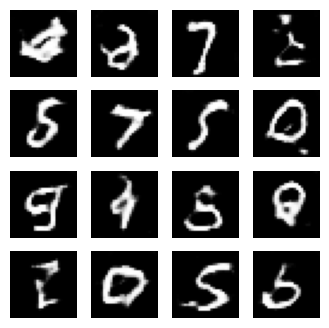

Epoch [2/10], Step [0/938], D Loss: 1.2243, G Loss: 0.5225
Epoch [2/10], Step [100/938], D Loss: 1.0010, G Loss: 0.8733
Epoch [2/10], Step [200/938], D Loss: 0.9517, G Loss: 1.1884
Epoch [2/10], Step [300/938], D Loss: 1.1788, G Loss: 1.3012
Epoch [2/10], Step [400/938], D Loss: 1.1965, G Loss: 1.5443
Epoch [2/10], Step [500/938], D Loss: 1.0282, G Loss: 0.9922
Epoch [2/10], Step [600/938], D Loss: 1.4748, G Loss: 1.5888
Epoch [2/10], Step [700/938], D Loss: 1.1016, G Loss: 0.8143
Epoch [2/10], Step [800/938], D Loss: 1.0569, G Loss: 0.8776
Epoch [2/10], Step [900/938], D Loss: 1.0395, G Loss: 0.8540


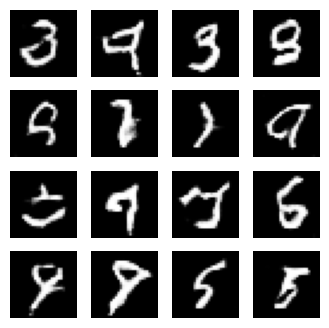

Epoch [3/10], Step [0/938], D Loss: 1.0258, G Loss: 1.3974
Epoch [3/10], Step [100/938], D Loss: 0.9385, G Loss: 1.1164
Epoch [3/10], Step [200/938], D Loss: 1.0546, G Loss: 0.8571
Epoch [3/10], Step [300/938], D Loss: 1.0994, G Loss: 1.8768
Epoch [3/10], Step [400/938], D Loss: 1.0602, G Loss: 1.0219
Epoch [3/10], Step [500/938], D Loss: 1.0313, G Loss: 0.9558
Epoch [3/10], Step [600/938], D Loss: 1.0936, G Loss: 2.0457
Epoch [3/10], Step [700/938], D Loss: 1.0860, G Loss: 0.8172
Epoch [3/10], Step [800/938], D Loss: 1.1002, G Loss: 1.1326
Epoch [3/10], Step [900/938], D Loss: 1.0921, G Loss: 0.8369


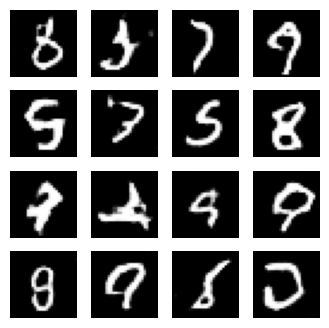

Epoch [4/10], Step [0/938], D Loss: 1.0678, G Loss: 1.6577
Epoch [4/10], Step [100/938], D Loss: 1.1938, G Loss: 0.6628
Epoch [4/10], Step [200/938], D Loss: 1.0704, G Loss: 1.3173
Epoch [4/10], Step [300/938], D Loss: 1.1361, G Loss: 0.6503
Epoch [4/10], Step [400/938], D Loss: 1.3746, G Loss: 1.8021
Epoch [4/10], Step [500/938], D Loss: 1.2356, G Loss: 1.9254
Epoch [4/10], Step [600/938], D Loss: 1.0996, G Loss: 0.9271
Epoch [4/10], Step [700/938], D Loss: 1.2019, G Loss: 0.9351
Epoch [4/10], Step [800/938], D Loss: 1.1611, G Loss: 1.1604
Epoch [4/10], Step [900/938], D Loss: 1.2407, G Loss: 1.2389


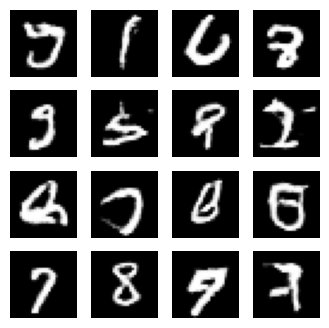

Epoch [5/10], Step [0/938], D Loss: 1.1937, G Loss: 0.8062
Epoch [5/10], Step [100/938], D Loss: 0.9827, G Loss: 1.1513
Epoch [5/10], Step [200/938], D Loss: 1.0773, G Loss: 1.0401
Epoch [5/10], Step [300/938], D Loss: 1.1032, G Loss: 1.4112
Epoch [5/10], Step [400/938], D Loss: 1.1182, G Loss: 0.8458
Epoch [5/10], Step [500/938], D Loss: 1.2215, G Loss: 1.0797
Epoch [5/10], Step [600/938], D Loss: 1.1991, G Loss: 1.0205
Epoch [5/10], Step [700/938], D Loss: 1.1484, G Loss: 0.8751
Epoch [5/10], Step [800/938], D Loss: 1.1400, G Loss: 1.1592
Epoch [5/10], Step [900/938], D Loss: 1.0992, G Loss: 1.2379


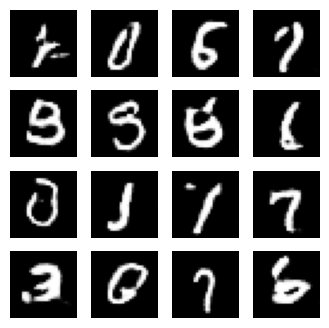

Epoch [6/10], Step [0/938], D Loss: 1.2716, G Loss: 1.4363
Epoch [6/10], Step [100/938], D Loss: 1.2056, G Loss: 1.1089
Epoch [6/10], Step [200/938], D Loss: 1.1298, G Loss: 0.9707
Epoch [6/10], Step [300/938], D Loss: 1.2565, G Loss: 1.1201
Epoch [6/10], Step [400/938], D Loss: 1.1679, G Loss: 1.3027
Epoch [6/10], Step [500/938], D Loss: 1.2102, G Loss: 1.3561
Epoch [6/10], Step [600/938], D Loss: 1.1528, G Loss: 0.9427
Epoch [6/10], Step [700/938], D Loss: 1.1402, G Loss: 0.8567
Epoch [6/10], Step [800/938], D Loss: 1.1602, G Loss: 1.0713
Epoch [6/10], Step [900/938], D Loss: 1.2230, G Loss: 1.1033


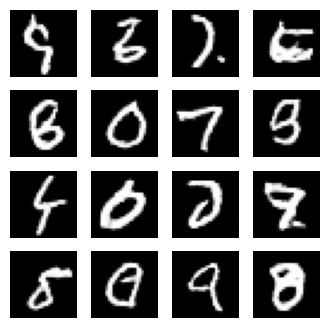

Epoch [7/10], Step [0/938], D Loss: 1.1785, G Loss: 1.0551
Epoch [7/10], Step [100/938], D Loss: 1.2744, G Loss: 0.7962
Epoch [7/10], Step [200/938], D Loss: 1.1423, G Loss: 1.2641
Epoch [7/10], Step [300/938], D Loss: 1.1643, G Loss: 0.8868
Epoch [7/10], Step [400/938], D Loss: 1.1356, G Loss: 1.0678
Epoch [7/10], Step [500/938], D Loss: 1.2201, G Loss: 1.0226
Epoch [7/10], Step [600/938], D Loss: 1.2426, G Loss: 0.7538
Epoch [7/10], Step [700/938], D Loss: 1.1695, G Loss: 1.1900
Epoch [7/10], Step [800/938], D Loss: 1.1899, G Loss: 1.0783
Epoch [7/10], Step [900/938], D Loss: 1.2016, G Loss: 0.9532


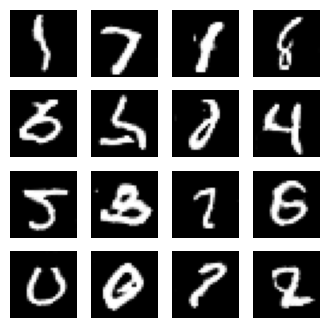

Epoch [8/10], Step [0/938], D Loss: 1.2846, G Loss: 1.3032
Epoch [8/10], Step [100/938], D Loss: 1.3108, G Loss: 0.8446
Epoch [8/10], Step [200/938], D Loss: 1.4924, G Loss: 0.7016
Epoch [8/10], Step [300/938], D Loss: 1.2335, G Loss: 1.1305
Epoch [8/10], Step [400/938], D Loss: 1.1267, G Loss: 1.3264
Epoch [8/10], Step [500/938], D Loss: 1.3782, G Loss: 0.9435
Epoch [8/10], Step [600/938], D Loss: 1.1406, G Loss: 1.1238
Epoch [8/10], Step [700/938], D Loss: 1.2169, G Loss: 0.8558
Epoch [8/10], Step [800/938], D Loss: 1.1581, G Loss: 0.8297
Epoch [8/10], Step [900/938], D Loss: 1.2014, G Loss: 0.8522


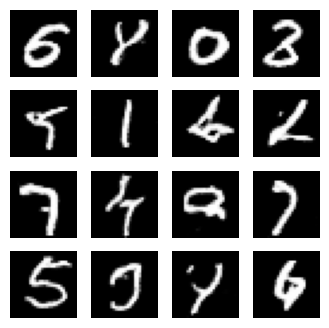

Epoch [9/10], Step [0/938], D Loss: 1.1294, G Loss: 1.1170
Epoch [9/10], Step [100/938], D Loss: 1.2779, G Loss: 1.0378
Epoch [9/10], Step [200/938], D Loss: 1.1752, G Loss: 0.8853
Epoch [9/10], Step [300/938], D Loss: 1.2601, G Loss: 0.9366
Epoch [9/10], Step [400/938], D Loss: 1.3218, G Loss: 0.8775
Epoch [9/10], Step [500/938], D Loss: 1.2275, G Loss: 0.9265
Epoch [9/10], Step [600/938], D Loss: 1.3248, G Loss: 1.0233
Epoch [9/10], Step [700/938], D Loss: 1.2890, G Loss: 0.9798
Epoch [9/10], Step [800/938], D Loss: 1.3174, G Loss: 0.8463
Epoch [9/10], Step [900/938], D Loss: 1.2553, G Loss: 0.8892


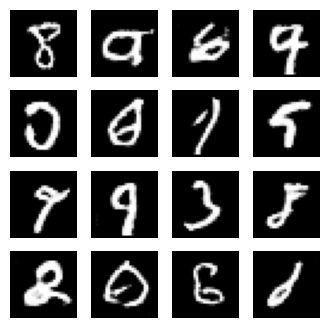

Epoch [10/10], Step [0/938], D Loss: 1.2878, G Loss: 1.0990
Epoch [10/10], Step [100/938], D Loss: 1.4557, G Loss: 0.7345
Epoch [10/10], Step [200/938], D Loss: 1.2893, G Loss: 1.0414
Epoch [10/10], Step [300/938], D Loss: 1.2797, G Loss: 0.9078
Epoch [10/10], Step [400/938], D Loss: 1.2542, G Loss: 1.1135
Epoch [10/10], Step [500/938], D Loss: 1.2707, G Loss: 1.1844
Epoch [10/10], Step [600/938], D Loss: 1.3130, G Loss: 1.1280
Epoch [10/10], Step [700/938], D Loss: 1.2174, G Loss: 1.0508
Epoch [10/10], Step [800/938], D Loss: 1.4689, G Loss: 0.6867
Epoch [10/10], Step [900/938], D Loss: 1.4435, G Loss: 0.9898


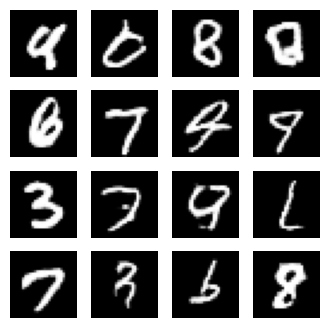

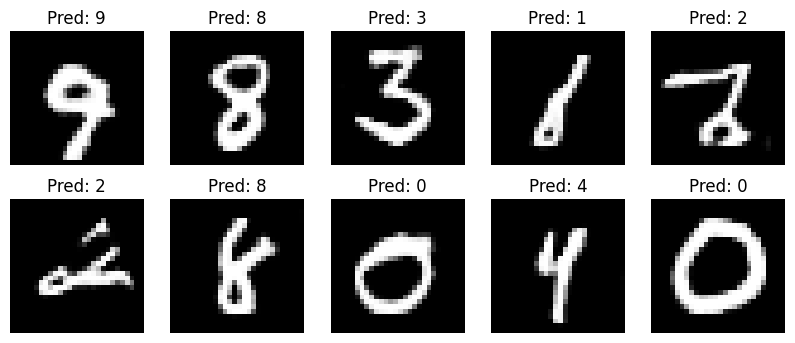

In [16]:
# Розмір вектору шуму, який подаємо на вхід Генератору
z_dim = 100

# Розмір зображення MNIST після "розгортання" в вектор
img_size = 28 * 28

optimizer_g_params = {"lr": 0.0002, "betas": (0.5, 0.999)}
optimizer_d_params = {"lr": 0.0002, "betas": (0.5, 0.999)}

generator = DCGANGenerator(z_dim=z_dim)
discriminator = DCGANDiscriminator()

trainer = Trainer(
    generator=generator,
    discriminator=discriminator,
    batch_size=32,
    device="cuda" if torch.cuda.is_available() else "cpu",
    optimizer_g=optim.Adam,
    optimizer_d=optim.Adam,
    optimizer_g_par=optimizer_g_params,
    optimizer_d_par=optimizer_d_params,
)

trainer.test_output

trainer.train(train_loader, 'gan', num_epochs=10)

#### Коефіцієнт навчання: Експериментуйте з різними значеннями коефіцієнта навчання (learning rate) для генератора і дискримінатора.


##### lr_g = 0.0002; lr_d = 0.002

Epoch [1/10], Step [0/938], D Loss: 1.5846, G Loss: 2.2150
Epoch [1/10], Step [100/938], D Loss: 0.3190, G Loss: 6.1043
Epoch [1/10], Step [200/938], D Loss: 1.1588, G Loss: 1.0069
Epoch [1/10], Step [300/938], D Loss: 0.6546, G Loss: 2.6012
Epoch [1/10], Step [400/938], D Loss: 0.9565, G Loss: 5.0841
Epoch [1/10], Step [500/938], D Loss: 0.7565, G Loss: 1.2518
Epoch [1/10], Step [600/938], D Loss: 1.0560, G Loss: 0.9381
Epoch [1/10], Step [700/938], D Loss: 0.9127, G Loss: 1.4302
Epoch [1/10], Step [800/938], D Loss: 0.9380, G Loss: 0.8862
Epoch [1/10], Step [900/938], D Loss: 0.8860, G Loss: 2.5214


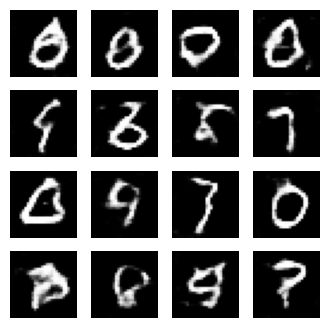

Epoch [2/10], Step [0/938], D Loss: 0.8715, G Loss: 1.2341
Epoch [2/10], Step [100/938], D Loss: 1.0384, G Loss: 0.9240
Epoch [2/10], Step [200/938], D Loss: 0.7856, G Loss: 1.0569
Epoch [2/10], Step [300/938], D Loss: 0.9965, G Loss: 1.1662
Epoch [2/10], Step [400/938], D Loss: 0.8942, G Loss: 2.2044
Epoch [2/10], Step [500/938], D Loss: 1.0263, G Loss: 1.1923
Epoch [2/10], Step [600/938], D Loss: 0.7975, G Loss: 1.8730
Epoch [2/10], Step [700/938], D Loss: 1.1480, G Loss: 2.8537
Epoch [2/10], Step [800/938], D Loss: 1.0775, G Loss: 2.8822
Epoch [2/10], Step [900/938], D Loss: 0.8351, G Loss: 1.2118


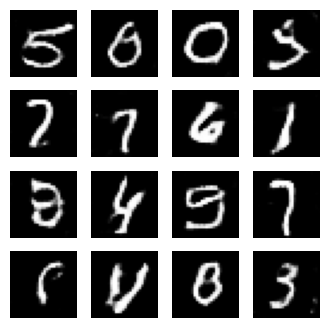

Epoch [3/10], Step [0/938], D Loss: 0.9786, G Loss: 0.9808
Epoch [3/10], Step [100/938], D Loss: 1.1530, G Loss: 1.0235
Epoch [3/10], Step [200/938], D Loss: 1.2841, G Loss: 0.7763
Epoch [3/10], Step [300/938], D Loss: 0.9907, G Loss: 1.2289
Epoch [3/10], Step [400/938], D Loss: 0.9679, G Loss: 1.0820
Epoch [3/10], Step [500/938], D Loss: 0.6821, G Loss: 2.0939
Epoch [3/10], Step [600/938], D Loss: 1.1424, G Loss: 0.9083
Epoch [3/10], Step [700/938], D Loss: 0.7341, G Loss: 2.2461
Epoch [3/10], Step [800/938], D Loss: 0.6598, G Loss: 1.8152
Epoch [3/10], Step [900/938], D Loss: 1.1039, G Loss: 0.7561


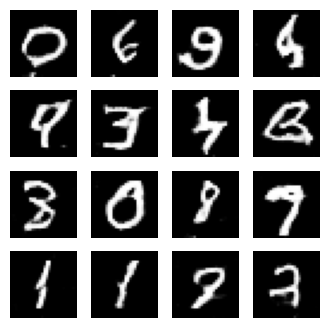

Epoch [4/10], Step [0/938], D Loss: 0.7563, G Loss: 2.8024
Epoch [4/10], Step [100/938], D Loss: 0.8397, G Loss: 2.9424
Epoch [4/10], Step [200/938], D Loss: 0.7776, G Loss: 1.6524
Epoch [4/10], Step [300/938], D Loss: 1.0357, G Loss: 1.5871
Epoch [4/10], Step [400/938], D Loss: 0.7866, G Loss: 1.9622
Epoch [4/10], Step [500/938], D Loss: 0.9771, G Loss: 3.1946
Epoch [4/10], Step [600/938], D Loss: 1.0066, G Loss: 1.7672
Epoch [4/10], Step [700/938], D Loss: 0.7845, G Loss: 1.3831
Epoch [4/10], Step [800/938], D Loss: 1.0588, G Loss: 1.9610
Epoch [4/10], Step [900/938], D Loss: 0.6570, G Loss: 2.1461


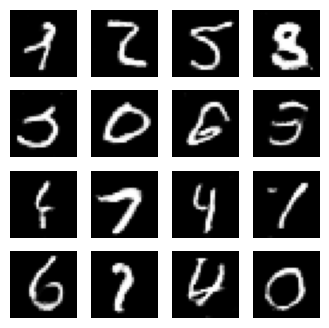

Epoch [5/10], Step [0/938], D Loss: 1.2556, G Loss: 3.0955
Epoch [5/10], Step [100/938], D Loss: 0.8087, G Loss: 1.2023
Epoch [5/10], Step [200/938], D Loss: 1.0916, G Loss: 1.0591
Epoch [5/10], Step [300/938], D Loss: 0.9607, G Loss: 2.8538
Epoch [5/10], Step [400/938], D Loss: 0.7493, G Loss: 1.7321
Epoch [5/10], Step [500/938], D Loss: 0.9707, G Loss: 1.2222
Epoch [5/10], Step [600/938], D Loss: 1.0522, G Loss: 2.5207
Epoch [5/10], Step [700/938], D Loss: 0.8599, G Loss: 1.4307
Epoch [5/10], Step [800/938], D Loss: 0.8766, G Loss: 1.9753
Epoch [5/10], Step [900/938], D Loss: 0.7429, G Loss: 2.1092


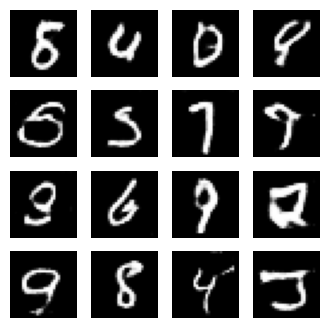

Epoch [6/10], Step [0/938], D Loss: 0.7561, G Loss: 2.5000
Epoch [6/10], Step [100/938], D Loss: 0.8545, G Loss: 1.4145
Epoch [6/10], Step [200/938], D Loss: 0.8690, G Loss: 1.3688
Epoch [6/10], Step [300/938], D Loss: 0.9147, G Loss: 2.0029
Epoch [6/10], Step [400/938], D Loss: 0.8316, G Loss: 1.7835
Epoch [6/10], Step [500/938], D Loss: 0.8968, G Loss: 2.3214
Epoch [6/10], Step [600/938], D Loss: 0.7375, G Loss: 1.4434
Epoch [6/10], Step [700/938], D Loss: 0.8508, G Loss: 2.0205
Epoch [6/10], Step [800/938], D Loss: 1.0296, G Loss: 1.7900
Epoch [6/10], Step [900/938], D Loss: 0.8614, G Loss: 1.4078


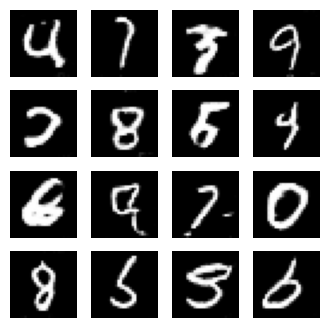

Epoch [7/10], Step [0/938], D Loss: 1.3104, G Loss: 0.8126
Epoch [7/10], Step [100/938], D Loss: 1.2283, G Loss: 0.8645
Epoch [7/10], Step [200/938], D Loss: 0.9731, G Loss: 2.2342
Epoch [7/10], Step [300/938], D Loss: 1.2664, G Loss: 3.1537
Epoch [7/10], Step [400/938], D Loss: 1.0992, G Loss: 2.3725
Epoch [7/10], Step [500/938], D Loss: 1.0040, G Loss: 2.4577
Epoch [7/10], Step [600/938], D Loss: 0.9791, G Loss: 1.2079
Epoch [7/10], Step [700/938], D Loss: 0.7539, G Loss: 2.7993
Epoch [7/10], Step [800/938], D Loss: 0.9661, G Loss: 1.5721
Epoch [7/10], Step [900/938], D Loss: 0.8968, G Loss: 3.2665


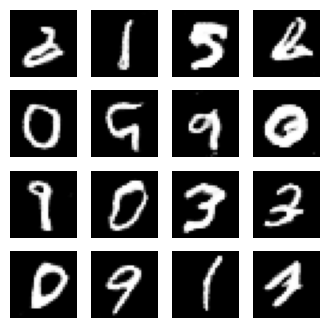

Epoch [8/10], Step [0/938], D Loss: 0.9236, G Loss: 1.6400
Epoch [8/10], Step [100/938], D Loss: 0.9608, G Loss: 3.0000
Epoch [8/10], Step [200/938], D Loss: 1.0377, G Loss: 1.4533
Epoch [8/10], Step [300/938], D Loss: 0.8565, G Loss: 2.0579
Epoch [8/10], Step [400/938], D Loss: 0.9057, G Loss: 2.9386
Epoch [8/10], Step [500/938], D Loss: 0.9710, G Loss: 2.5694
Epoch [8/10], Step [600/938], D Loss: 0.6591, G Loss: 1.5122
Epoch [8/10], Step [700/938], D Loss: 0.9165, G Loss: 1.9005
Epoch [8/10], Step [800/938], D Loss: 1.6081, G Loss: 3.1198
Epoch [8/10], Step [900/938], D Loss: 1.2375, G Loss: 2.6566


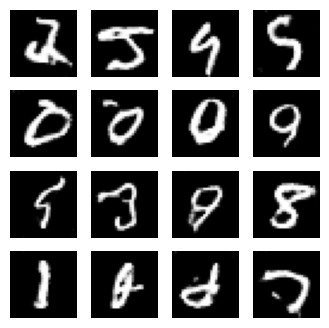

Epoch [9/10], Step [0/938], D Loss: 1.1126, G Loss: 2.7280
Epoch [9/10], Step [100/938], D Loss: 1.0261, G Loss: 2.8060
Epoch [9/10], Step [200/938], D Loss: 1.1023, G Loss: 1.0454
Epoch [9/10], Step [300/938], D Loss: 1.2689, G Loss: 1.6325
Epoch [9/10], Step [400/938], D Loss: 0.6543, G Loss: 1.3344
Epoch [9/10], Step [500/938], D Loss: 0.7989, G Loss: 1.6232
Epoch [9/10], Step [600/938], D Loss: 0.7884, G Loss: 1.1443
Epoch [9/10], Step [700/938], D Loss: 0.7056, G Loss: 2.0221
Epoch [9/10], Step [800/938], D Loss: 0.9852, G Loss: 2.6317
Epoch [9/10], Step [900/938], D Loss: 0.9486, G Loss: 1.9201


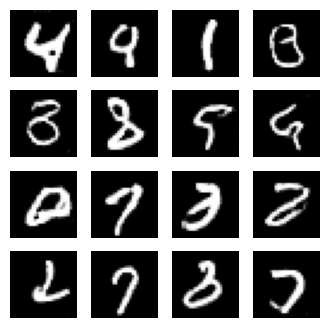

Epoch [10/10], Step [0/938], D Loss: 0.9548, G Loss: 3.0338
Epoch [10/10], Step [100/938], D Loss: 1.1296, G Loss: 0.7129
Epoch [10/10], Step [200/938], D Loss: 0.5743, G Loss: 1.7131
Epoch [10/10], Step [300/938], D Loss: 1.1741, G Loss: 3.0281
Epoch [10/10], Step [400/938], D Loss: 1.2039, G Loss: 1.3415
Epoch [10/10], Step [500/938], D Loss: 1.1639, G Loss: 3.2997
Epoch [10/10], Step [600/938], D Loss: 1.0281, G Loss: 1.0082
Epoch [10/10], Step [700/938], D Loss: 0.7272, G Loss: 2.4332
Epoch [10/10], Step [800/938], D Loss: 1.0353, G Loss: 2.5079
Epoch [10/10], Step [900/938], D Loss: 0.6473, G Loss: 2.7303


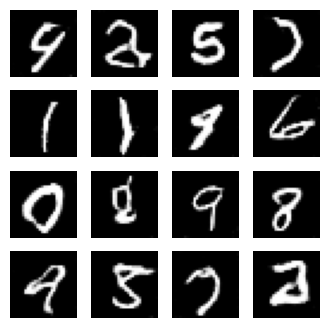

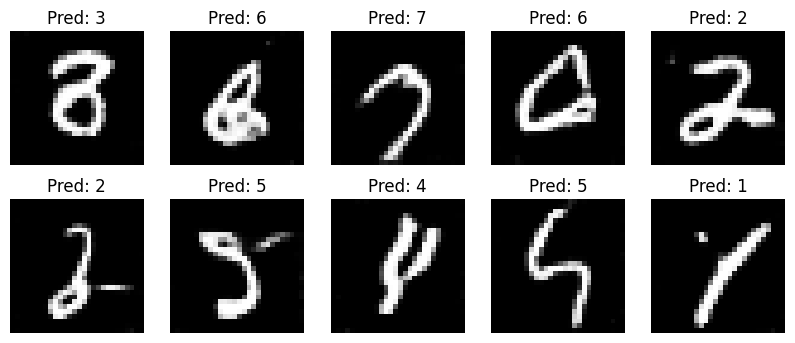

In [17]:
# Розмір вектору шуму, який подаємо на вхід Генератору
z_dim = 100

# Розмір зображення MNIST після "розгортання" в вектор
img_size = 28 * 28

optimizer_g_params = {"lr": 0.0002, "betas": (0.5, 0.999)}
optimizer_d_params = {"lr": 0.002, "betas": (0.5, 0.999)}

generator = DCGANGenerator(z_dim=z_dim)
discriminator = DCGANDiscriminator()

trainer = Trainer(
    generator=generator,
    discriminator=discriminator,
    batch_size=64,
    device="cuda" if torch.cuda.is_available() else "cpu",
    optimizer_g=optim.Adam,
    optimizer_d=optim.Adam,
    optimizer_g_par=optimizer_g_params,
    optimizer_d_par=optimizer_d_params,
)

trainer.test_output

trainer.train(train_loader, 'gan', num_epochs=10)

##### lr = 0.0001; betas=(0.5, 0.9)

Epoch [1/10], Step [0/938], D Loss: 1.4563, G Loss: 0.9009
Epoch [1/10], Step [100/938], D Loss: 0.6199, G Loss: 2.2583
Epoch [1/10], Step [200/938], D Loss: 1.2578, G Loss: 0.8068
Epoch [1/10], Step [300/938], D Loss: 1.1138, G Loss: 0.9836
Epoch [1/10], Step [400/938], D Loss: 0.8747, G Loss: 1.1281
Epoch [1/10], Step [500/938], D Loss: 0.7918, G Loss: 1.3924
Epoch [1/10], Step [600/938], D Loss: 0.9593, G Loss: 0.9314
Epoch [1/10], Step [700/938], D Loss: 0.9042, G Loss: 1.2591
Epoch [1/10], Step [800/938], D Loss: 0.9483, G Loss: 1.1085
Epoch [1/10], Step [900/938], D Loss: 1.0338, G Loss: 0.9225


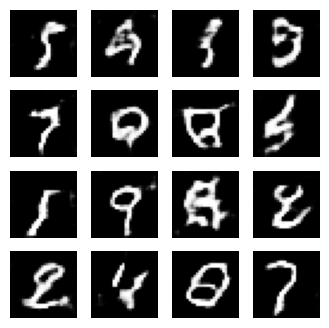

Epoch [2/10], Step [0/938], D Loss: 1.1492, G Loss: 0.7996
Epoch [2/10], Step [100/938], D Loss: 1.1107, G Loss: 1.1224
Epoch [2/10], Step [200/938], D Loss: 1.1174, G Loss: 1.1741
Epoch [2/10], Step [300/938], D Loss: 1.1443, G Loss: 1.0298
Epoch [2/10], Step [400/938], D Loss: 1.0165, G Loss: 0.9710
Epoch [2/10], Step [500/938], D Loss: 1.1478, G Loss: 1.2426
Epoch [2/10], Step [600/938], D Loss: 1.0639, G Loss: 1.1054
Epoch [2/10], Step [700/938], D Loss: 1.0757, G Loss: 1.0106
Epoch [2/10], Step [800/938], D Loss: 1.1064, G Loss: 1.3126
Epoch [2/10], Step [900/938], D Loss: 1.0625, G Loss: 0.9549


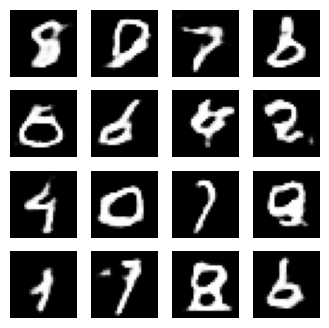

Epoch [3/10], Step [0/938], D Loss: 1.0556, G Loss: 0.7507
Epoch [3/10], Step [100/938], D Loss: 1.0211, G Loss: 1.4474
Epoch [3/10], Step [200/938], D Loss: 0.9214, G Loss: 1.1527
Epoch [3/10], Step [300/938], D Loss: 0.9636, G Loss: 1.1967
Epoch [3/10], Step [400/938], D Loss: 1.0106, G Loss: 1.3480
Epoch [3/10], Step [500/938], D Loss: 1.0077, G Loss: 0.9293
Epoch [3/10], Step [600/938], D Loss: 1.0085, G Loss: 1.2456
Epoch [3/10], Step [700/938], D Loss: 1.1646, G Loss: 0.7593
Epoch [3/10], Step [800/938], D Loss: 1.1067, G Loss: 0.6273
Epoch [3/10], Step [900/938], D Loss: 1.1184, G Loss: 1.1677


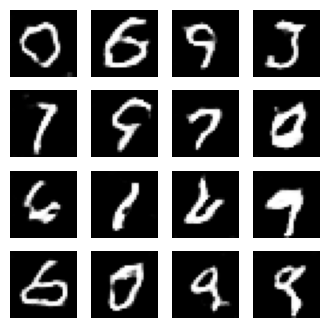

Epoch [4/10], Step [0/938], D Loss: 1.0874, G Loss: 1.5530
Epoch [4/10], Step [100/938], D Loss: 1.0227, G Loss: 1.0422
Epoch [4/10], Step [200/938], D Loss: 1.0241, G Loss: 1.3033
Epoch [4/10], Step [300/938], D Loss: 1.0772, G Loss: 1.0820
Epoch [4/10], Step [400/938], D Loss: 1.0473, G Loss: 0.8991
Epoch [4/10], Step [500/938], D Loss: 1.1439, G Loss: 0.9740
Epoch [4/10], Step [600/938], D Loss: 1.0939, G Loss: 0.7853
Epoch [4/10], Step [700/938], D Loss: 1.0990, G Loss: 0.8541
Epoch [4/10], Step [800/938], D Loss: 1.0702, G Loss: 0.7367
Epoch [4/10], Step [900/938], D Loss: 1.1811, G Loss: 0.4892


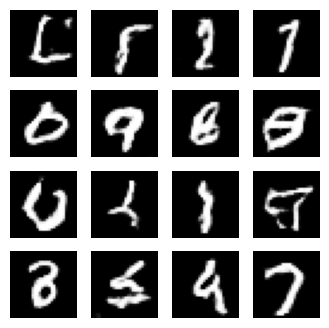

Epoch [5/10], Step [0/938], D Loss: 1.1095, G Loss: 1.2180
Epoch [5/10], Step [100/938], D Loss: 1.1146, G Loss: 1.3990
Epoch [5/10], Step [200/938], D Loss: 1.2265, G Loss: 1.5844
Epoch [5/10], Step [300/938], D Loss: 1.1210, G Loss: 1.2133
Epoch [5/10], Step [400/938], D Loss: 1.1531, G Loss: 1.1472
Epoch [5/10], Step [500/938], D Loss: 1.2145, G Loss: 0.7550
Epoch [5/10], Step [600/938], D Loss: 1.2858, G Loss: 0.8361
Epoch [5/10], Step [700/938], D Loss: 1.0864, G Loss: 0.8506
Epoch [5/10], Step [800/938], D Loss: 1.1509, G Loss: 1.0358
Epoch [5/10], Step [900/938], D Loss: 1.1583, G Loss: 0.8506


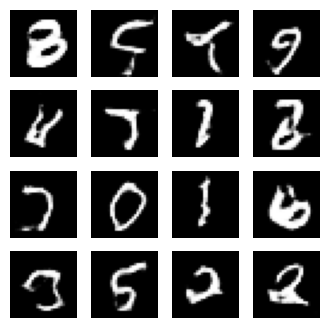

Epoch [6/10], Step [0/938], D Loss: 1.2173, G Loss: 1.1232
Epoch [6/10], Step [100/938], D Loss: 1.0678, G Loss: 1.0560
Epoch [6/10], Step [200/938], D Loss: 1.3941, G Loss: 0.5555
Epoch [6/10], Step [300/938], D Loss: 0.9603, G Loss: 1.2971
Epoch [6/10], Step [400/938], D Loss: 1.1314, G Loss: 1.2038
Epoch [6/10], Step [500/938], D Loss: 1.0153, G Loss: 1.2113
Epoch [6/10], Step [600/938], D Loss: 1.2650, G Loss: 0.6111
Epoch [6/10], Step [700/938], D Loss: 1.1069, G Loss: 1.2087
Epoch [6/10], Step [800/938], D Loss: 1.2037, G Loss: 0.8619
Epoch [6/10], Step [900/938], D Loss: 1.0695, G Loss: 0.8172


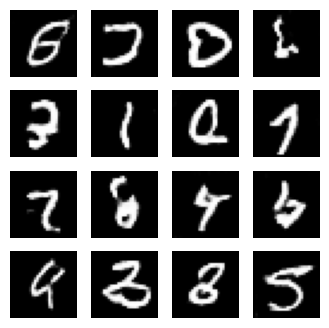

Epoch [7/10], Step [0/938], D Loss: 1.1223, G Loss: 1.4151
Epoch [7/10], Step [100/938], D Loss: 1.1485, G Loss: 0.8225
Epoch [7/10], Step [200/938], D Loss: 1.1515, G Loss: 1.0396
Epoch [7/10], Step [300/938], D Loss: 1.3507, G Loss: 0.5823
Epoch [7/10], Step [400/938], D Loss: 1.1814, G Loss: 1.4059
Epoch [7/10], Step [500/938], D Loss: 1.2817, G Loss: 0.7271
Epoch [7/10], Step [600/938], D Loss: 1.1321, G Loss: 1.0518
Epoch [7/10], Step [700/938], D Loss: 1.1613, G Loss: 1.2174
Epoch [7/10], Step [800/938], D Loss: 1.1627, G Loss: 1.1148
Epoch [7/10], Step [900/938], D Loss: 1.1690, G Loss: 1.0834


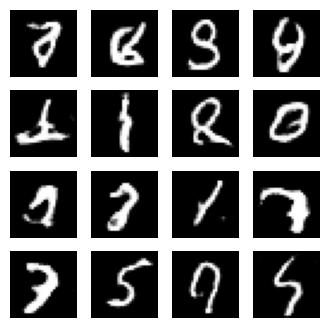

Epoch [8/10], Step [0/938], D Loss: 1.2069, G Loss: 1.1709
Epoch [8/10], Step [100/938], D Loss: 1.2710, G Loss: 0.6755
Epoch [8/10], Step [200/938], D Loss: 1.1133, G Loss: 0.9740
Epoch [8/10], Step [300/938], D Loss: 1.0479, G Loss: 1.0344
Epoch [8/10], Step [400/938], D Loss: 1.0373, G Loss: 1.1973
Epoch [8/10], Step [500/938], D Loss: 1.1791, G Loss: 1.0618
Epoch [8/10], Step [600/938], D Loss: 1.0421, G Loss: 1.0536
Epoch [8/10], Step [700/938], D Loss: 1.0638, G Loss: 0.9949
Epoch [8/10], Step [800/938], D Loss: 1.3522, G Loss: 1.1159
Epoch [8/10], Step [900/938], D Loss: 1.3618, G Loss: 0.6189


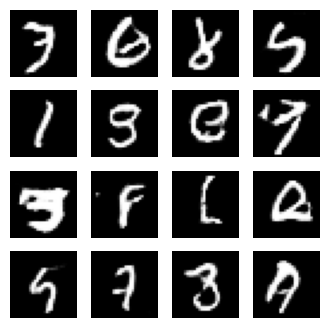

Epoch [9/10], Step [0/938], D Loss: 1.1290, G Loss: 1.1106
Epoch [9/10], Step [100/938], D Loss: 1.1083, G Loss: 1.2823
Epoch [9/10], Step [200/938], D Loss: 1.2405, G Loss: 0.8563
Epoch [9/10], Step [300/938], D Loss: 1.0993, G Loss: 1.3465
Epoch [9/10], Step [400/938], D Loss: 1.2031, G Loss: 0.8433
Epoch [9/10], Step [500/938], D Loss: 1.1426, G Loss: 1.3974
Epoch [9/10], Step [600/938], D Loss: 1.1684, G Loss: 1.0260
Epoch [9/10], Step [700/938], D Loss: 1.2645, G Loss: 0.8751
Epoch [9/10], Step [800/938], D Loss: 1.2878, G Loss: 1.2589
Epoch [9/10], Step [900/938], D Loss: 1.2854, G Loss: 0.8343


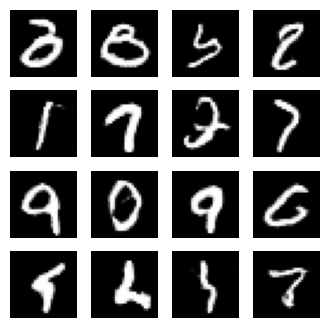

Epoch [10/10], Step [0/938], D Loss: 1.1306, G Loss: 0.6563
Epoch [10/10], Step [100/938], D Loss: 1.2381, G Loss: 0.9212
Epoch [10/10], Step [200/938], D Loss: 1.1040, G Loss: 1.1093
Epoch [10/10], Step [300/938], D Loss: 1.3506, G Loss: 0.5257
Epoch [10/10], Step [400/938], D Loss: 1.2342, G Loss: 1.2255
Epoch [10/10], Step [500/938], D Loss: 1.2356, G Loss: 1.2036
Epoch [10/10], Step [600/938], D Loss: 1.1713, G Loss: 1.3676
Epoch [10/10], Step [700/938], D Loss: 1.3515, G Loss: 1.1195
Epoch [10/10], Step [800/938], D Loss: 1.1678, G Loss: 1.1967
Epoch [10/10], Step [900/938], D Loss: 1.2552, G Loss: 1.1386


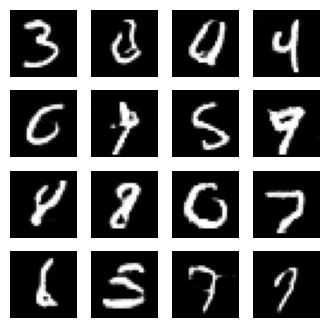

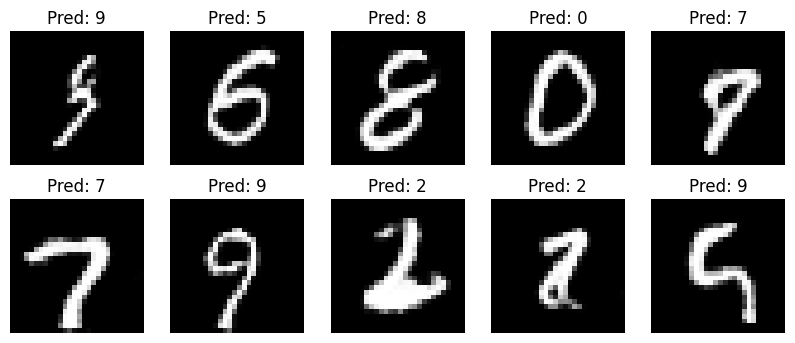

In [18]:
# Розмір вектору шуму, який подаємо на вхід Генератору
z_dim = 100

# Розмір зображення MNIST після "розгортання" в вектор
img_size = 28 * 28

optimizer_g_params = {"lr": 0.0001, "betas": (0.5, 0.9)}
optimizer_d_params = {"lr": 0.0001, "betas": (0.5, 0.9)}

generator = DCGANGenerator(z_dim=z_dim)
discriminator = DCGANDiscriminator()

trainer = Trainer(
    generator=generator,
    discriminator=discriminator,
    batch_size=64,
    device="cuda" if torch.cuda.is_available() else "cpu",
    optimizer_g=optim.Adam,
    optimizer_d=optim.Adam,
    optimizer_g_par=optimizer_g_params,
    optimizer_d_par=optimizer_d_params,
)

trainer.test_output

trainer.train(train_loader, 'gan', num_epochs=10)


#### Регуляризація: Додайте Dropout до дискримінатора, щоб запобігти перенавчанню.


##### dropout_p=0.4

Epoch [1/10], Step [0/938], D Loss: 1.3715, G Loss: 0.7440
Epoch [1/10], Step [100/938], D Loss: 1.4671, G Loss: 0.8484
Epoch [1/10], Step [200/938], D Loss: 1.4358, G Loss: 0.7493
Epoch [1/10], Step [300/938], D Loss: 1.3351, G Loss: 0.7354
Epoch [1/10], Step [400/938], D Loss: 1.2930, G Loss: 0.8089
Epoch [1/10], Step [500/938], D Loss: 1.2400, G Loss: 0.7430
Epoch [1/10], Step [600/938], D Loss: 1.1772, G Loss: 0.9577
Epoch [1/10], Step [700/938], D Loss: 1.0581, G Loss: 1.0698
Epoch [1/10], Step [800/938], D Loss: 1.1669, G Loss: 0.8393
Epoch [1/10], Step [900/938], D Loss: 1.2920, G Loss: 0.9142


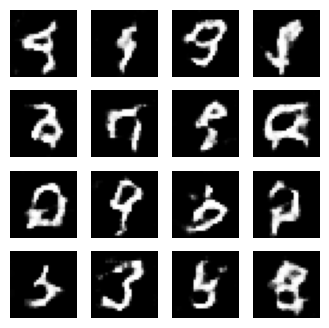

Epoch [2/10], Step [0/938], D Loss: 1.2164, G Loss: 0.9723
Epoch [2/10], Step [100/938], D Loss: 1.2476, G Loss: 0.9596
Epoch [2/10], Step [200/938], D Loss: 1.3926, G Loss: 0.8207
Epoch [2/10], Step [300/938], D Loss: 1.2809, G Loss: 0.8504
Epoch [2/10], Step [400/938], D Loss: 1.4160, G Loss: 0.7783
Epoch [2/10], Step [500/938], D Loss: 1.3601, G Loss: 0.8303
Epoch [2/10], Step [600/938], D Loss: 1.3740, G Loss: 0.8151
Epoch [2/10], Step [700/938], D Loss: 1.3061, G Loss: 0.7695
Epoch [2/10], Step [800/938], D Loss: 1.2793, G Loss: 0.8335
Epoch [2/10], Step [900/938], D Loss: 1.2969, G Loss: 0.7859


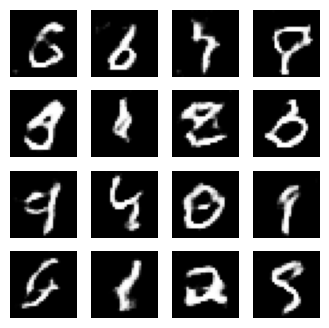

Epoch [3/10], Step [0/938], D Loss: 1.2889, G Loss: 0.7805
Epoch [3/10], Step [100/938], D Loss: 1.3365, G Loss: 0.9454
Epoch [3/10], Step [200/938], D Loss: 1.3574, G Loss: 0.7317
Epoch [3/10], Step [300/938], D Loss: 1.3754, G Loss: 0.8227
Epoch [3/10], Step [400/938], D Loss: 1.3322, G Loss: 0.8288
Epoch [3/10], Step [500/938], D Loss: 1.4230, G Loss: 0.7431
Epoch [3/10], Step [600/938], D Loss: 1.3330, G Loss: 0.8511
Epoch [3/10], Step [700/938], D Loss: 1.3972, G Loss: 0.8256
Epoch [3/10], Step [800/938], D Loss: 1.3289, G Loss: 0.7941
Epoch [3/10], Step [900/938], D Loss: 1.3120, G Loss: 0.8225


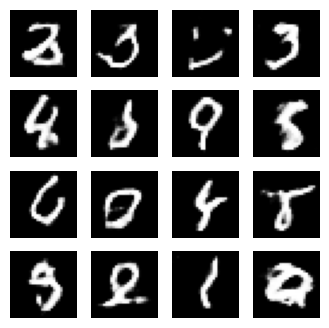

Epoch [4/10], Step [0/938], D Loss: 1.3274, G Loss: 0.7877
Epoch [4/10], Step [100/938], D Loss: 1.3912, G Loss: 0.8711
Epoch [4/10], Step [200/938], D Loss: 1.3615, G Loss: 0.7430
Epoch [4/10], Step [300/938], D Loss: 1.3720, G Loss: 0.7078
Epoch [4/10], Step [400/938], D Loss: 1.3444, G Loss: 0.7621
Epoch [4/10], Step [500/938], D Loss: 1.3679, G Loss: 0.8701
Epoch [4/10], Step [600/938], D Loss: 1.3391, G Loss: 0.8610
Epoch [4/10], Step [700/938], D Loss: 1.4152, G Loss: 0.7855
Epoch [4/10], Step [800/938], D Loss: 1.2343, G Loss: 0.8716
Epoch [4/10], Step [900/938], D Loss: 1.2508, G Loss: 0.7797


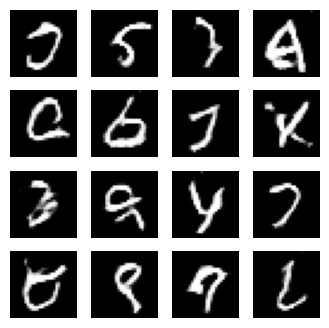

Epoch [5/10], Step [0/938], D Loss: 1.3522, G Loss: 0.7260
Epoch [5/10], Step [100/938], D Loss: 1.3974, G Loss: 0.7775
Epoch [5/10], Step [200/938], D Loss: 1.4096, G Loss: 0.8197
Epoch [5/10], Step [300/938], D Loss: 1.2640, G Loss: 0.8799
Epoch [5/10], Step [400/938], D Loss: 1.2503, G Loss: 0.8304
Epoch [5/10], Step [500/938], D Loss: 1.4148, G Loss: 0.6830
Epoch [5/10], Step [600/938], D Loss: 1.3073, G Loss: 0.8649
Epoch [5/10], Step [700/938], D Loss: 1.4079, G Loss: 0.7579
Epoch [5/10], Step [800/938], D Loss: 1.3739, G Loss: 0.8118
Epoch [5/10], Step [900/938], D Loss: 1.4219, G Loss: 0.7756


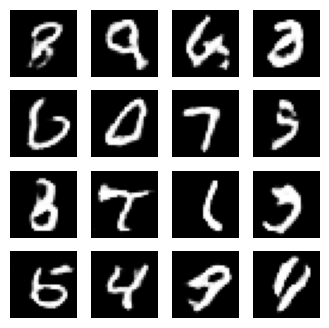

Epoch [6/10], Step [0/938], D Loss: 1.3390, G Loss: 0.8731
Epoch [6/10], Step [100/938], D Loss: 1.4543, G Loss: 0.7467
Epoch [6/10], Step [200/938], D Loss: 1.3712, G Loss: 0.7580
Epoch [6/10], Step [300/938], D Loss: 1.3417, G Loss: 0.8152
Epoch [6/10], Step [400/938], D Loss: 1.4099, G Loss: 0.7907
Epoch [6/10], Step [500/938], D Loss: 1.3551, G Loss: 0.8058
Epoch [6/10], Step [600/938], D Loss: 1.4097, G Loss: 0.8107
Epoch [6/10], Step [700/938], D Loss: 1.3486, G Loss: 0.6619
Epoch [6/10], Step [800/938], D Loss: 1.2934, G Loss: 0.7076
Epoch [6/10], Step [900/938], D Loss: 1.3455, G Loss: 0.7055


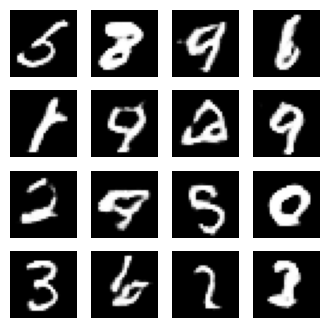

Epoch [7/10], Step [0/938], D Loss: 1.3724, G Loss: 0.7813
Epoch [7/10], Step [100/938], D Loss: 1.4988, G Loss: 0.6914
Epoch [7/10], Step [200/938], D Loss: 1.3441, G Loss: 0.8337
Epoch [7/10], Step [300/938], D Loss: 1.4059, G Loss: 0.7425
Epoch [7/10], Step [400/938], D Loss: 1.3949, G Loss: 0.7828
Epoch [7/10], Step [500/938], D Loss: 1.3415, G Loss: 0.7832
Epoch [7/10], Step [600/938], D Loss: 1.3270, G Loss: 0.7779
Epoch [7/10], Step [700/938], D Loss: 1.2821, G Loss: 0.7932
Epoch [7/10], Step [800/938], D Loss: 1.2791, G Loss: 0.8101
Epoch [7/10], Step [900/938], D Loss: 1.3858, G Loss: 0.8470


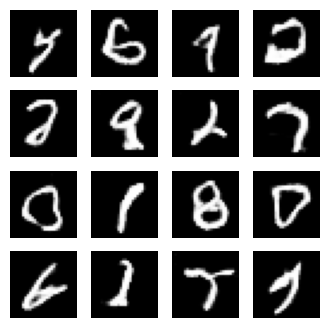

Epoch [8/10], Step [0/938], D Loss: 1.4789, G Loss: 0.7595
Epoch [8/10], Step [100/938], D Loss: 1.4532, G Loss: 0.8118
Epoch [8/10], Step [200/938], D Loss: 1.3325, G Loss: 0.8313
Epoch [8/10], Step [300/938], D Loss: 1.3471, G Loss: 0.7671
Epoch [8/10], Step [400/938], D Loss: 1.3009, G Loss: 0.7976
Epoch [8/10], Step [500/938], D Loss: 1.3633, G Loss: 0.8385
Epoch [8/10], Step [600/938], D Loss: 1.3471, G Loss: 0.6871
Epoch [8/10], Step [700/938], D Loss: 1.4537, G Loss: 0.6886
Epoch [8/10], Step [800/938], D Loss: 1.3013, G Loss: 0.7150
Epoch [8/10], Step [900/938], D Loss: 1.3421, G Loss: 0.7682


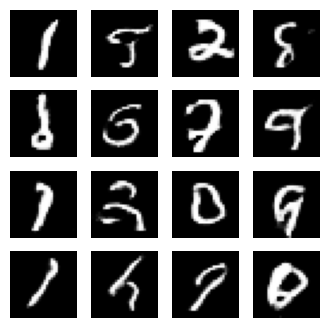

Epoch [9/10], Step [0/938], D Loss: 1.2857, G Loss: 0.7727
Epoch [9/10], Step [100/938], D Loss: 1.4374, G Loss: 0.7707
Epoch [9/10], Step [200/938], D Loss: 1.3677, G Loss: 0.7574
Epoch [9/10], Step [300/938], D Loss: 1.3539, G Loss: 0.8185
Epoch [9/10], Step [400/938], D Loss: 1.4258, G Loss: 0.6960
Epoch [9/10], Step [500/938], D Loss: 1.3817, G Loss: 0.7994
Epoch [9/10], Step [600/938], D Loss: 1.3890, G Loss: 0.7170
Epoch [9/10], Step [700/938], D Loss: 1.3739, G Loss: 0.7379
Epoch [9/10], Step [800/938], D Loss: 1.4665, G Loss: 0.7178
Epoch [9/10], Step [900/938], D Loss: 1.4053, G Loss: 0.7924


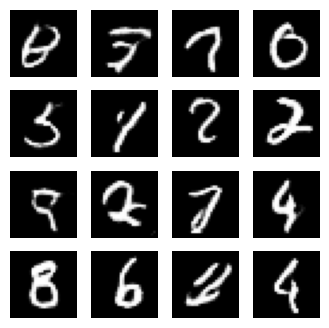

Epoch [10/10], Step [0/938], D Loss: 1.3690, G Loss: 0.7675
Epoch [10/10], Step [100/938], D Loss: 1.3808, G Loss: 0.8065
Epoch [10/10], Step [200/938], D Loss: 1.4096, G Loss: 0.7861
Epoch [10/10], Step [300/938], D Loss: 1.3645, G Loss: 0.7933
Epoch [10/10], Step [400/938], D Loss: 1.4447, G Loss: 0.7631
Epoch [10/10], Step [500/938], D Loss: 1.4137, G Loss: 0.7693
Epoch [10/10], Step [600/938], D Loss: 1.3511, G Loss: 0.6837
Epoch [10/10], Step [700/938], D Loss: 1.3754, G Loss: 0.7700
Epoch [10/10], Step [800/938], D Loss: 1.3814, G Loss: 0.8595
Epoch [10/10], Step [900/938], D Loss: 1.4263, G Loss: 0.8037


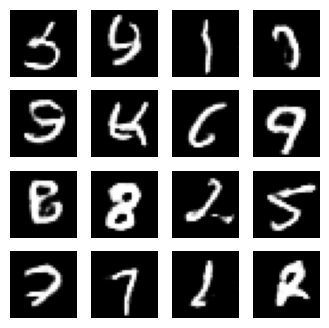

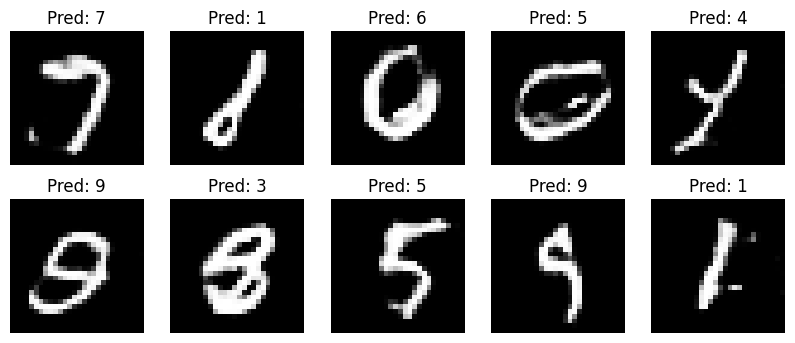

In [19]:
# Розмір вектору шуму, який подаємо на вхід Генератору
z_dim = 100

# Розмір зображення MNIST після "розгортання" в вектор
img_size = 28 * 28

optimizer_g_params = {"lr": 0.0002, "betas": (0.5, 0.999)}
optimizer_d_params = {"lr": 0.0002, "betas": (0.5, 0.999)}

generator = DCGANGenerator(z_dim=z_dim)
discriminator = DCGANDiscriminatorDO(dropout_p=0.4)

trainer = Trainer(
    generator=generator,
    discriminator=discriminator,
    batch_size=64,
    device="cuda" if torch.cuda.is_available() else "cpu",
    optimizer_g=optim.Adam,
    optimizer_d=optim.Adam,
    optimizer_g_par=optimizer_g_params,
    optimizer_d_par=optimizer_d_params,
)

trainer.test_output

trainer.train(train_loader, 'gan', num_epochs=10)


#### Зміна оптимізаторів: Використайте оптимізатори Adam, RMSprop або інші для покращення швидкості збіжності.

Epoch [1/10], Step [0/938], D Loss: 1.3581, G Loss: 1.3861
Epoch [1/10], Step [100/938], D Loss: 1.2674, G Loss: 0.9460
Epoch [1/10], Step [200/938], D Loss: 1.2470, G Loss: 0.8911
Epoch [1/10], Step [300/938], D Loss: 1.2601, G Loss: 0.9666
Epoch [1/10], Step [400/938], D Loss: 1.2234, G Loss: 0.8879
Epoch [1/10], Step [500/938], D Loss: 1.0668, G Loss: 1.0990
Epoch [1/10], Step [600/938], D Loss: 0.9770, G Loss: 1.0095
Epoch [1/10], Step [700/938], D Loss: 0.9272, G Loss: 0.8997
Epoch [1/10], Step [800/938], D Loss: 0.8877, G Loss: 1.1734
Epoch [1/10], Step [900/938], D Loss: 0.8235, G Loss: 1.0884


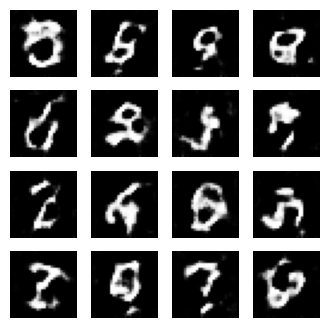

Epoch [2/10], Step [0/938], D Loss: 1.0066, G Loss: 1.1558
Epoch [2/10], Step [100/938], D Loss: 0.9212, G Loss: 1.2737
Epoch [2/10], Step [200/938], D Loss: 1.0094, G Loss: 0.8717
Epoch [2/10], Step [300/938], D Loss: 1.2102, G Loss: 1.4228
Epoch [2/10], Step [400/938], D Loss: 1.1016, G Loss: 0.7082
Epoch [2/10], Step [500/938], D Loss: 1.1662, G Loss: 1.4162
Epoch [2/10], Step [600/938], D Loss: 1.0633, G Loss: 0.8441
Epoch [2/10], Step [700/938], D Loss: 1.1181, G Loss: 0.7797
Epoch [2/10], Step [800/938], D Loss: 1.1185, G Loss: 1.1955
Epoch [2/10], Step [900/938], D Loss: 1.1118, G Loss: 0.8836


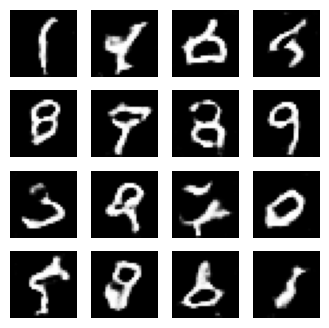

Epoch [3/10], Step [0/938], D Loss: 1.1808, G Loss: 1.0432
Epoch [3/10], Step [100/938], D Loss: 1.1332, G Loss: 0.7352
Epoch [3/10], Step [200/938], D Loss: 1.1523, G Loss: 0.7035
Epoch [3/10], Step [300/938], D Loss: 1.1037, G Loss: 0.8073
Epoch [3/10], Step [400/938], D Loss: 1.1251, G Loss: 1.0055
Epoch [3/10], Step [500/938], D Loss: 1.0704, G Loss: 1.0852
Epoch [3/10], Step [600/938], D Loss: 1.1464, G Loss: 0.6697
Epoch [3/10], Step [700/938], D Loss: 1.1456, G Loss: 0.9368
Epoch [3/10], Step [800/938], D Loss: 1.0809, G Loss: 1.1588
Epoch [3/10], Step [900/938], D Loss: 1.0656, G Loss: 0.9025


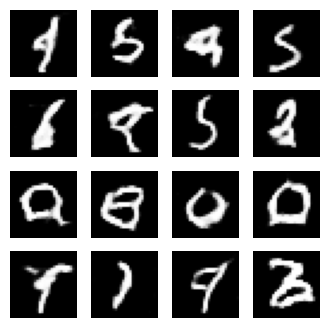

Epoch [4/10], Step [0/938], D Loss: 1.0776, G Loss: 1.0279
Epoch [4/10], Step [100/938], D Loss: 1.0133, G Loss: 1.0240
Epoch [4/10], Step [200/938], D Loss: 1.0644, G Loss: 0.8630
Epoch [4/10], Step [300/938], D Loss: 1.1148, G Loss: 0.6324
Epoch [4/10], Step [400/938], D Loss: 1.1477, G Loss: 0.7333
Epoch [4/10], Step [500/938], D Loss: 1.1403, G Loss: 0.8960
Epoch [4/10], Step [600/938], D Loss: 1.1737, G Loss: 0.6059
Epoch [4/10], Step [700/938], D Loss: 1.0719, G Loss: 0.7695
Epoch [4/10], Step [800/938], D Loss: 1.0267, G Loss: 0.9157
Epoch [4/10], Step [900/938], D Loss: 0.9786, G Loss: 1.1572


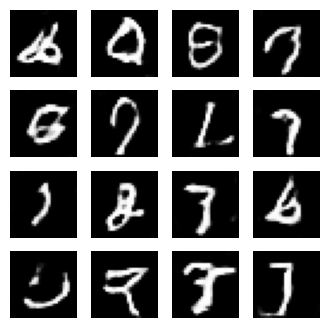

Epoch [5/10], Step [0/938], D Loss: 1.1408, G Loss: 0.9928
Epoch [5/10], Step [100/938], D Loss: 1.1212, G Loss: 1.0844
Epoch [5/10], Step [200/938], D Loss: 1.0127, G Loss: 0.8895
Epoch [5/10], Step [300/938], D Loss: 1.1078, G Loss: 0.7844
Epoch [5/10], Step [400/938], D Loss: 1.0597, G Loss: 0.8522
Epoch [5/10], Step [500/938], D Loss: 1.0763, G Loss: 1.2054
Epoch [5/10], Step [600/938], D Loss: 1.0755, G Loss: 0.8195
Epoch [5/10], Step [700/938], D Loss: 1.1572, G Loss: 0.6956
Epoch [5/10], Step [800/938], D Loss: 1.1591, G Loss: 0.6895
Epoch [5/10], Step [900/938], D Loss: 1.1094, G Loss: 0.7640


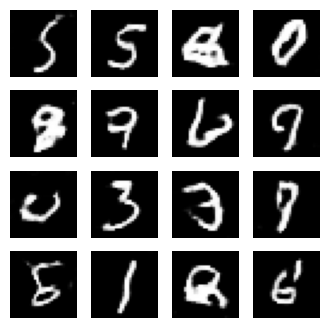

Epoch [6/10], Step [0/938], D Loss: 1.1115, G Loss: 1.1693
Epoch [6/10], Step [100/938], D Loss: 0.9831, G Loss: 0.9822
Epoch [6/10], Step [200/938], D Loss: 1.1181, G Loss: 0.9022
Epoch [6/10], Step [300/938], D Loss: 1.1830, G Loss: 1.3629
Epoch [6/10], Step [400/938], D Loss: 1.1192, G Loss: 0.8723
Epoch [6/10], Step [500/938], D Loss: 1.0899, G Loss: 0.8882
Epoch [6/10], Step [600/938], D Loss: 1.2399, G Loss: 0.5838
Epoch [6/10], Step [700/938], D Loss: 1.0824, G Loss: 1.0387
Epoch [6/10], Step [800/938], D Loss: 1.1851, G Loss: 1.2047
Epoch [6/10], Step [900/938], D Loss: 1.1771, G Loss: 0.8355


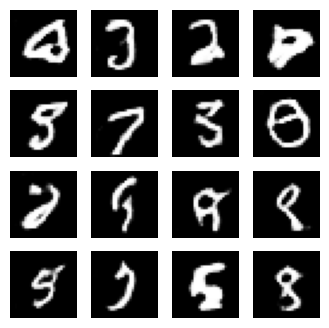

Epoch [7/10], Step [0/938], D Loss: 1.0321, G Loss: 0.9646
Epoch [7/10], Step [100/938], D Loss: 1.0583, G Loss: 0.9348
Epoch [7/10], Step [200/938], D Loss: 1.3096, G Loss: 0.5423
Epoch [7/10], Step [300/938], D Loss: 1.3382, G Loss: 0.4625
Epoch [7/10], Step [400/938], D Loss: 1.1512, G Loss: 1.1016
Epoch [7/10], Step [500/938], D Loss: 1.1730, G Loss: 0.7358
Epoch [7/10], Step [600/938], D Loss: 1.2033, G Loss: 1.0874
Epoch [7/10], Step [700/938], D Loss: 1.2799, G Loss: 1.3918
Epoch [7/10], Step [800/938], D Loss: 1.1571, G Loss: 0.6854
Epoch [7/10], Step [900/938], D Loss: 1.1444, G Loss: 0.8571


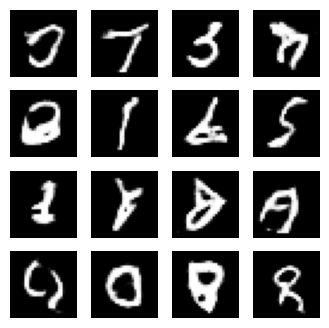

Epoch [8/10], Step [0/938], D Loss: 1.1964, G Loss: 0.7089
Epoch [8/10], Step [100/938], D Loss: 1.1345, G Loss: 1.0420
Epoch [8/10], Step [200/938], D Loss: 1.1350, G Loss: 0.8345
Epoch [8/10], Step [300/938], D Loss: 1.1206, G Loss: 0.8815
Epoch [8/10], Step [400/938], D Loss: 1.0949, G Loss: 1.1121
Epoch [8/10], Step [500/938], D Loss: 1.1006, G Loss: 0.9407
Epoch [8/10], Step [600/938], D Loss: 1.0629, G Loss: 1.0469
Epoch [8/10], Step [700/938], D Loss: 1.1637, G Loss: 0.8483
Epoch [8/10], Step [800/938], D Loss: 1.1321, G Loss: 1.0137
Epoch [8/10], Step [900/938], D Loss: 1.1753, G Loss: 0.8363


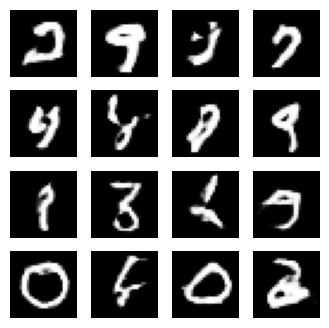

Epoch [9/10], Step [0/938], D Loss: 1.2560, G Loss: 0.6133
Epoch [9/10], Step [100/938], D Loss: 1.0402, G Loss: 1.2626
Epoch [9/10], Step [200/938], D Loss: 1.1645, G Loss: 1.0677
Epoch [9/10], Step [300/938], D Loss: 1.1131, G Loss: 1.3420
Epoch [9/10], Step [400/938], D Loss: 1.2201, G Loss: 1.4802
Epoch [9/10], Step [500/938], D Loss: 1.0961, G Loss: 0.7737
Epoch [9/10], Step [600/938], D Loss: 1.1191, G Loss: 0.7771
Epoch [9/10], Step [700/938], D Loss: 1.2330, G Loss: 0.6775
Epoch [9/10], Step [800/938], D Loss: 1.1034, G Loss: 1.0414
Epoch [9/10], Step [900/938], D Loss: 1.2595, G Loss: 0.6897


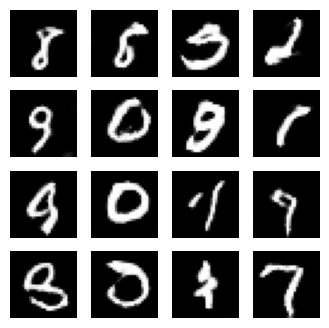

Epoch [10/10], Step [0/938], D Loss: 1.0830, G Loss: 0.8891
Epoch [10/10], Step [100/938], D Loss: 1.1802, G Loss: 0.8056
Epoch [10/10], Step [200/938], D Loss: 1.1424, G Loss: 0.8166
Epoch [10/10], Step [300/938], D Loss: 1.0893, G Loss: 1.0310
Epoch [10/10], Step [400/938], D Loss: 1.1840, G Loss: 0.7084
Epoch [10/10], Step [500/938], D Loss: 1.1937, G Loss: 0.7168
Epoch [10/10], Step [600/938], D Loss: 1.1358, G Loss: 1.1091
Epoch [10/10], Step [700/938], D Loss: 1.0601, G Loss: 0.8928
Epoch [10/10], Step [800/938], D Loss: 1.1972, G Loss: 1.4131
Epoch [10/10], Step [900/938], D Loss: 1.0917, G Loss: 0.8360


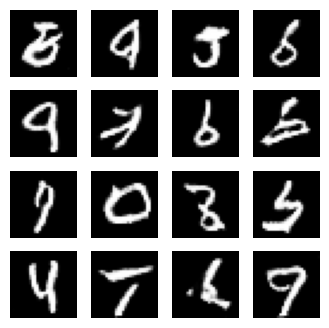

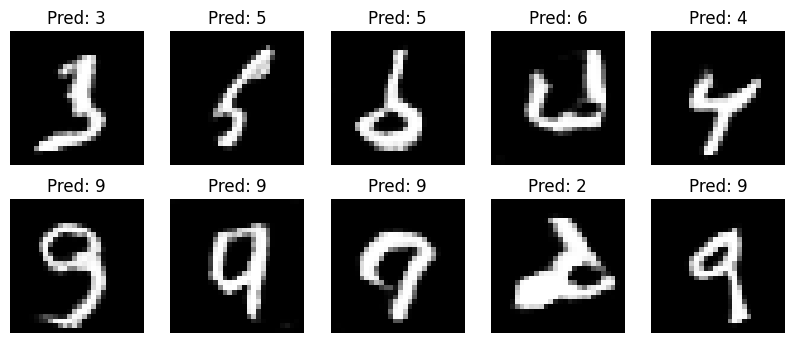

In [20]:
# Розмір вектору шуму, який подаємо на вхід Генератору
z_dim = 100

optimizer_g_params = {"lr": 0.00005, "alpha": 0.99, "eps": 1e-08}  # параметри для RMSprop
optimizer_d_params = {"lr": 0.00005, "alpha": 0.99, "eps": 1e-08}


generator = DCGANGenerator(z_dim=z_dim)
discriminator = DCGANDiscriminator()

trainer = Trainer(
    generator=generator,
    discriminator=discriminator,
    batch_size=64,
    device="cuda" if torch.cuda.is_available() else "cpu",
    optimizer_g=optim.RMSprop,       # Замість optim.Adam
    optimizer_d=optim.RMSprop,       # Замість optim.Adam
    optimizer_g_par=optimizer_g_params,
    optimizer_d_par=optimizer_d_params,
)

trainer.train(train_loader, 'gan', num_epochs=10)

#### Кількість епох (num_epochs):
Для MNIST 10 епох часто недостатньо, хоча інколи і цього вистачає, щоб побачити перший результат. Спробуймо збільшити число епох до 30, аби дати моделям більше часу на навчання.

Epoch [1/30], Step [0/938], D Loss: 1.2789, G Loss: 0.9181
Epoch [1/30], Step [100/938], D Loss: 1.0351, G Loss: 2.1170
Epoch [1/30], Step [200/938], D Loss: 1.1519, G Loss: 0.9820
Epoch [1/30], Step [300/938], D Loss: 1.0229, G Loss: 1.6716
Epoch [1/30], Step [400/938], D Loss: 0.8969, G Loss: 0.6433
Epoch [1/30], Step [500/938], D Loss: 0.7583, G Loss: 1.8257
Epoch [1/30], Step [600/938], D Loss: 0.9693, G Loss: 1.0814
Epoch [1/30], Step [700/938], D Loss: 0.9259, G Loss: 0.9515
Epoch [1/30], Step [800/938], D Loss: 0.9449, G Loss: 1.0806
Epoch [1/30], Step [900/938], D Loss: 1.0304, G Loss: 0.8307


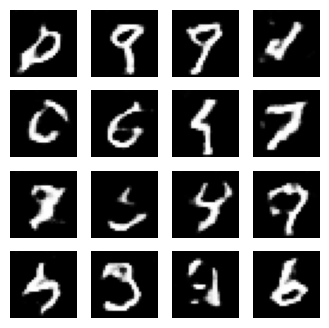

Epoch [2/30], Step [0/938], D Loss: 1.0034, G Loss: 1.1198
Epoch [2/30], Step [100/938], D Loss: 0.9244, G Loss: 1.5044
Epoch [2/30], Step [200/938], D Loss: 1.0585, G Loss: 0.7825
Epoch [2/30], Step [300/938], D Loss: 0.9584, G Loss: 1.3750
Epoch [2/30], Step [400/938], D Loss: 1.0625, G Loss: 1.4237
Epoch [2/30], Step [500/938], D Loss: 0.9651, G Loss: 1.4184
Epoch [2/30], Step [600/938], D Loss: 1.0891, G Loss: 0.6233
Epoch [2/30], Step [700/938], D Loss: 0.8683, G Loss: 1.3507
Epoch [2/30], Step [800/938], D Loss: 1.0215, G Loss: 0.9748
Epoch [2/30], Step [900/938], D Loss: 1.1521, G Loss: 1.0731


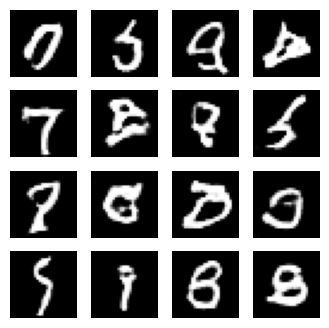

Epoch [3/30], Step [0/938], D Loss: 1.0254, G Loss: 1.4265
Epoch [3/30], Step [100/938], D Loss: 1.0556, G Loss: 1.3146
Epoch [3/30], Step [200/938], D Loss: 0.9763, G Loss: 0.9644
Epoch [3/30], Step [300/938], D Loss: 1.0551, G Loss: 1.0748
Epoch [3/30], Step [400/938], D Loss: 1.1654, G Loss: 1.1886
Epoch [3/30], Step [500/938], D Loss: 1.0301, G Loss: 1.6546
Epoch [3/30], Step [600/938], D Loss: 1.1346, G Loss: 1.2278
Epoch [3/30], Step [700/938], D Loss: 1.0325, G Loss: 1.3551
Epoch [3/30], Step [800/938], D Loss: 1.0453, G Loss: 1.2258
Epoch [3/30], Step [900/938], D Loss: 1.1916, G Loss: 1.3957


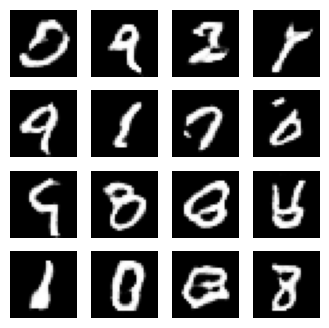

Epoch [4/30], Step [0/938], D Loss: 1.1876, G Loss: 1.2442
Epoch [4/30], Step [100/938], D Loss: 0.9967, G Loss: 1.3111
Epoch [4/30], Step [200/938], D Loss: 1.0249, G Loss: 1.0764
Epoch [4/30], Step [300/938], D Loss: 1.0304, G Loss: 1.3891
Epoch [4/30], Step [400/938], D Loss: 1.0403, G Loss: 1.3628
Epoch [4/30], Step [500/938], D Loss: 1.0024, G Loss: 1.2892
Epoch [4/30], Step [600/938], D Loss: 1.3436, G Loss: 0.7048
Epoch [4/30], Step [700/938], D Loss: 0.9844, G Loss: 1.2430
Epoch [4/30], Step [800/938], D Loss: 1.0867, G Loss: 1.2279
Epoch [4/30], Step [900/938], D Loss: 1.1314, G Loss: 0.8562


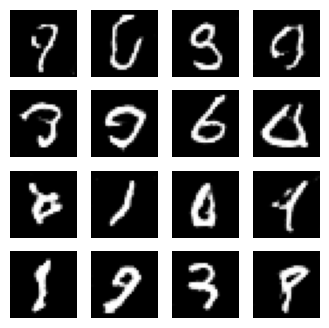

Epoch [5/30], Step [0/938], D Loss: 1.1343, G Loss: 1.2774
Epoch [5/30], Step [100/938], D Loss: 1.2227, G Loss: 0.7862
Epoch [5/30], Step [200/938], D Loss: 1.1136, G Loss: 1.1056
Epoch [5/30], Step [300/938], D Loss: 1.2170, G Loss: 1.5901
Epoch [5/30], Step [400/938], D Loss: 1.0878, G Loss: 1.4108
Epoch [5/30], Step [500/938], D Loss: 1.0465, G Loss: 1.1661
Epoch [5/30], Step [600/938], D Loss: 1.1651, G Loss: 0.8664
Epoch [5/30], Step [700/938], D Loss: 1.1186, G Loss: 1.2179
Epoch [5/30], Step [800/938], D Loss: 1.0400, G Loss: 1.4815
Epoch [5/30], Step [900/938], D Loss: 1.0574, G Loss: 1.1056


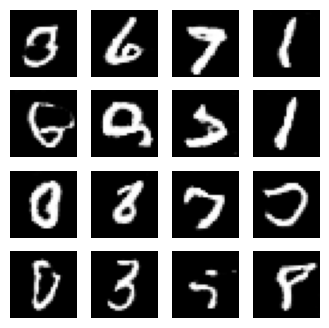

Epoch [6/30], Step [0/938], D Loss: 1.1451, G Loss: 1.4426
Epoch [6/30], Step [100/938], D Loss: 1.1163, G Loss: 0.9633
Epoch [6/30], Step [200/938], D Loss: 1.2417, G Loss: 1.0504
Epoch [6/30], Step [300/938], D Loss: 1.0810, G Loss: 1.5865
Epoch [6/30], Step [400/938], D Loss: 1.0401, G Loss: 1.3295
Epoch [6/30], Step [500/938], D Loss: 0.9480, G Loss: 1.5109
Epoch [6/30], Step [600/938], D Loss: 1.0739, G Loss: 1.2739
Epoch [6/30], Step [700/938], D Loss: 1.2262, G Loss: 1.2786
Epoch [6/30], Step [800/938], D Loss: 1.0260, G Loss: 1.1638
Epoch [6/30], Step [900/938], D Loss: 1.0822, G Loss: 1.2319


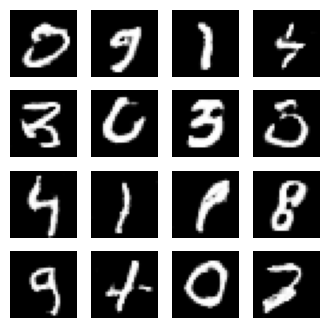

Epoch [7/30], Step [0/938], D Loss: 1.1736, G Loss: 1.0156
Epoch [7/30], Step [100/938], D Loss: 1.3130, G Loss: 0.7975
Epoch [7/30], Step [200/938], D Loss: 1.1322, G Loss: 1.0381
Epoch [7/30], Step [300/938], D Loss: 1.1378, G Loss: 1.0403
Epoch [7/30], Step [400/938], D Loss: 1.1461, G Loss: 1.3608
Epoch [7/30], Step [500/938], D Loss: 1.0421, G Loss: 1.3775
Epoch [7/30], Step [600/938], D Loss: 1.2643, G Loss: 1.0214
Epoch [7/30], Step [700/938], D Loss: 1.1433, G Loss: 0.9230
Epoch [7/30], Step [800/938], D Loss: 1.1704, G Loss: 1.0642
Epoch [7/30], Step [900/938], D Loss: 1.2398, G Loss: 1.0174


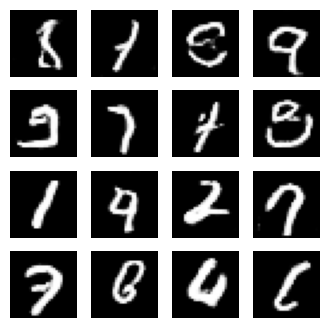

Epoch [8/30], Step [0/938], D Loss: 1.1815, G Loss: 1.1512
Epoch [8/30], Step [100/938], D Loss: 1.2833, G Loss: 0.9843
Epoch [8/30], Step [200/938], D Loss: 1.1741, G Loss: 1.2280
Epoch [8/30], Step [300/938], D Loss: 1.1909, G Loss: 1.1967
Epoch [8/30], Step [400/938], D Loss: 1.0623, G Loss: 0.9423
Epoch [8/30], Step [500/938], D Loss: 1.1922, G Loss: 1.0667
Epoch [8/30], Step [600/938], D Loss: 1.1415, G Loss: 1.1794
Epoch [8/30], Step [700/938], D Loss: 1.4081, G Loss: 0.9599
Epoch [8/30], Step [800/938], D Loss: 1.1020, G Loss: 0.9454
Epoch [8/30], Step [900/938], D Loss: 1.1912, G Loss: 1.1216


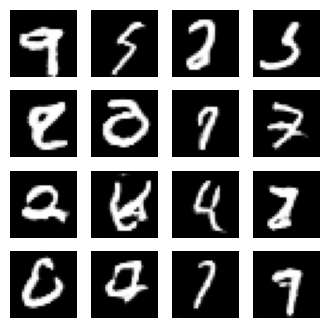

Epoch [9/30], Step [0/938], D Loss: 1.1581, G Loss: 0.8543
Epoch [9/30], Step [100/938], D Loss: 1.1452, G Loss: 1.1638
Epoch [9/30], Step [200/938], D Loss: 1.2273, G Loss: 0.9123
Epoch [9/30], Step [300/938], D Loss: 1.2154, G Loss: 1.3059
Epoch [9/30], Step [400/938], D Loss: 1.2366, G Loss: 1.1605
Epoch [9/30], Step [500/938], D Loss: 1.2068, G Loss: 0.9859
Epoch [9/30], Step [600/938], D Loss: 1.1549, G Loss: 1.1817
Epoch [9/30], Step [700/938], D Loss: 1.2282, G Loss: 1.1340
Epoch [9/30], Step [800/938], D Loss: 1.2846, G Loss: 0.8751
Epoch [9/30], Step [900/938], D Loss: 1.2741, G Loss: 1.0721


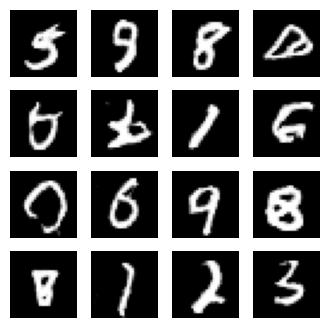

Epoch [10/30], Step [0/938], D Loss: 1.2259, G Loss: 1.0512
Epoch [10/30], Step [100/938], D Loss: 1.2992, G Loss: 1.0893
Epoch [10/30], Step [200/938], D Loss: 1.2539, G Loss: 1.1241
Epoch [10/30], Step [300/938], D Loss: 1.2769, G Loss: 0.7213
Epoch [10/30], Step [400/938], D Loss: 1.3546, G Loss: 1.0015
Epoch [10/30], Step [500/938], D Loss: 1.1642, G Loss: 1.1133
Epoch [10/30], Step [600/938], D Loss: 1.2288, G Loss: 0.9450
Epoch [10/30], Step [700/938], D Loss: 1.3074, G Loss: 0.9334
Epoch [10/30], Step [800/938], D Loss: 1.3362, G Loss: 0.8926
Epoch [10/30], Step [900/938], D Loss: 1.0356, G Loss: 1.0467


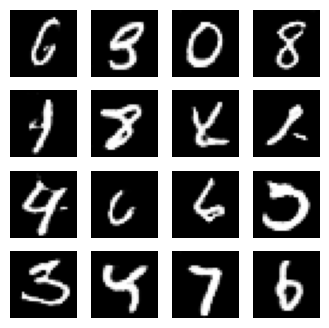

Epoch [11/30], Step [0/938], D Loss: 1.2541, G Loss: 1.0373
Epoch [11/30], Step [100/938], D Loss: 1.2381, G Loss: 1.1564
Epoch [11/30], Step [200/938], D Loss: 1.2792, G Loss: 0.9935
Epoch [11/30], Step [300/938], D Loss: 1.1616, G Loss: 0.9416
Epoch [11/30], Step [400/938], D Loss: 1.2011, G Loss: 1.1410
Epoch [11/30], Step [500/938], D Loss: 1.1419, G Loss: 1.0205
Epoch [11/30], Step [600/938], D Loss: 1.1591, G Loss: 1.0319
Epoch [11/30], Step [700/938], D Loss: 1.3144, G Loss: 0.8111
Epoch [11/30], Step [800/938], D Loss: 1.2214, G Loss: 1.1205
Epoch [11/30], Step [900/938], D Loss: 1.3026, G Loss: 0.9376


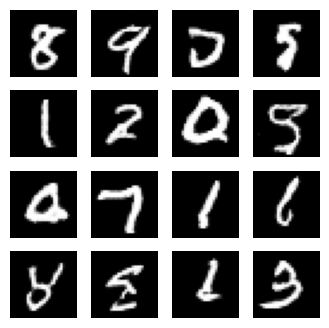

Epoch [12/30], Step [0/938], D Loss: 1.2603, G Loss: 1.1799
Epoch [12/30], Step [100/938], D Loss: 1.1662, G Loss: 1.0277
Epoch [12/30], Step [200/938], D Loss: 1.2162, G Loss: 0.8329
Epoch [12/30], Step [300/938], D Loss: 1.2217, G Loss: 1.0076
Epoch [12/30], Step [400/938], D Loss: 1.3013, G Loss: 0.8507
Epoch [12/30], Step [500/938], D Loss: 1.3313, G Loss: 0.9872
Epoch [12/30], Step [600/938], D Loss: 1.3791, G Loss: 0.7587
Epoch [12/30], Step [700/938], D Loss: 1.1057, G Loss: 0.9536
Epoch [12/30], Step [800/938], D Loss: 1.3498, G Loss: 0.9231
Epoch [12/30], Step [900/938], D Loss: 1.2943, G Loss: 0.9107


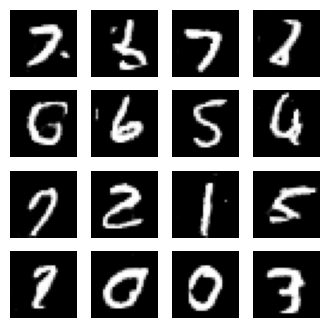

Epoch [13/30], Step [0/938], D Loss: 1.3655, G Loss: 1.0087
Epoch [13/30], Step [100/938], D Loss: 1.3509, G Loss: 0.6522
Epoch [13/30], Step [200/938], D Loss: 1.2505, G Loss: 1.0612
Epoch [13/30], Step [300/938], D Loss: 1.3308, G Loss: 0.8864
Epoch [13/30], Step [400/938], D Loss: 1.3443, G Loss: 0.8110
Epoch [13/30], Step [500/938], D Loss: 1.3350, G Loss: 0.9004
Epoch [13/30], Step [600/938], D Loss: 1.2692, G Loss: 0.8833
Epoch [13/30], Step [700/938], D Loss: 1.3280, G Loss: 0.8040
Epoch [13/30], Step [800/938], D Loss: 1.3340, G Loss: 0.7180
Epoch [13/30], Step [900/938], D Loss: 1.3091, G Loss: 1.1323


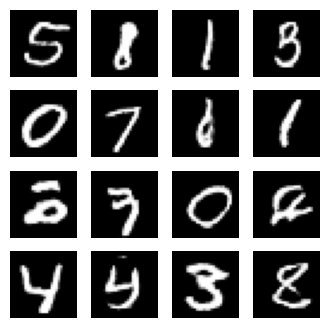

Epoch [14/30], Step [0/938], D Loss: 1.1934, G Loss: 0.9148
Epoch [14/30], Step [100/938], D Loss: 1.2623, G Loss: 0.8120
Epoch [14/30], Step [200/938], D Loss: 1.3250, G Loss: 0.9647
Epoch [14/30], Step [300/938], D Loss: 1.2548, G Loss: 0.8959
Epoch [14/30], Step [400/938], D Loss: 1.2819, G Loss: 0.9085
Epoch [14/30], Step [500/938], D Loss: 1.2754, G Loss: 0.8548
Epoch [14/30], Step [600/938], D Loss: 1.2875, G Loss: 0.9204
Epoch [14/30], Step [700/938], D Loss: 1.2727, G Loss: 0.8791
Epoch [14/30], Step [800/938], D Loss: 1.2645, G Loss: 0.9058
Epoch [14/30], Step [900/938], D Loss: 1.2484, G Loss: 0.9640


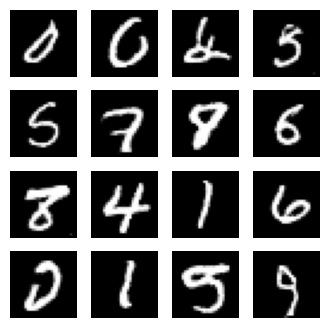

Epoch [15/30], Step [0/938], D Loss: 1.3019, G Loss: 0.8067
Epoch [15/30], Step [100/938], D Loss: 1.3295, G Loss: 0.7396
Epoch [15/30], Step [200/938], D Loss: 1.3998, G Loss: 1.0601
Epoch [15/30], Step [300/938], D Loss: 1.3567, G Loss: 0.8373
Epoch [15/30], Step [400/938], D Loss: 1.3698, G Loss: 0.8436
Epoch [15/30], Step [500/938], D Loss: 1.2691, G Loss: 0.9794
Epoch [15/30], Step [600/938], D Loss: 1.3910, G Loss: 0.7862
Epoch [15/30], Step [700/938], D Loss: 1.1989, G Loss: 0.9714
Epoch [15/30], Step [800/938], D Loss: 1.3714, G Loss: 0.7236
Epoch [15/30], Step [900/938], D Loss: 1.3305, G Loss: 0.9388


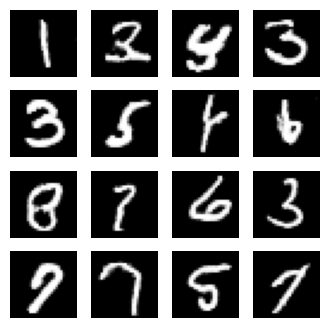

Epoch [16/30], Step [0/938], D Loss: 1.2773, G Loss: 0.8616
Epoch [16/30], Step [100/938], D Loss: 1.2908, G Loss: 1.0154
Epoch [16/30], Step [200/938], D Loss: 1.2452, G Loss: 0.8845
Epoch [16/30], Step [300/938], D Loss: 1.2703, G Loss: 1.0005
Epoch [16/30], Step [400/938], D Loss: 1.1887, G Loss: 0.9713
Epoch [16/30], Step [500/938], D Loss: 1.3186, G Loss: 0.9615
Epoch [16/30], Step [600/938], D Loss: 1.2851, G Loss: 0.9022
Epoch [16/30], Step [700/938], D Loss: 1.4723, G Loss: 0.8196
Epoch [16/30], Step [800/938], D Loss: 1.3825, G Loss: 0.8068
Epoch [16/30], Step [900/938], D Loss: 1.3896, G Loss: 0.8836


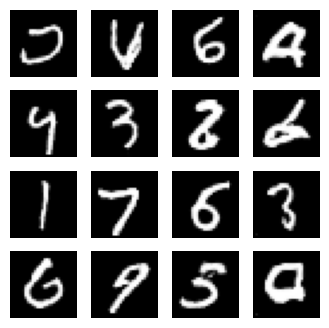

Epoch [17/30], Step [0/938], D Loss: 1.2816, G Loss: 0.8096
Epoch [17/30], Step [100/938], D Loss: 1.3515, G Loss: 0.7871
Epoch [17/30], Step [200/938], D Loss: 1.3599, G Loss: 0.9022
Epoch [17/30], Step [300/938], D Loss: 1.2817, G Loss: 0.8693
Epoch [17/30], Step [400/938], D Loss: 1.3803, G Loss: 0.8313
Epoch [17/30], Step [500/938], D Loss: 1.1745, G Loss: 0.9489
Epoch [17/30], Step [600/938], D Loss: 1.2395, G Loss: 0.8806
Epoch [17/30], Step [700/938], D Loss: 1.4136, G Loss: 0.8295
Epoch [17/30], Step [800/938], D Loss: 1.2848, G Loss: 0.9147
Epoch [17/30], Step [900/938], D Loss: 1.1585, G Loss: 1.1412


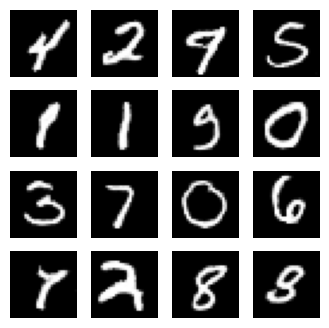

Epoch [18/30], Step [0/938], D Loss: 1.4160, G Loss: 0.6471
Epoch [18/30], Step [100/938], D Loss: 1.2907, G Loss: 0.8154
Epoch [18/30], Step [200/938], D Loss: 1.2478, G Loss: 0.9118
Epoch [18/30], Step [300/938], D Loss: 1.3553, G Loss: 0.7063
Epoch [18/30], Step [400/938], D Loss: 1.4416, G Loss: 0.6800
Epoch [18/30], Step [500/938], D Loss: 1.3209, G Loss: 0.8836
Epoch [18/30], Step [600/938], D Loss: 1.2111, G Loss: 0.8842
Epoch [18/30], Step [700/938], D Loss: 1.3651, G Loss: 0.7780
Epoch [18/30], Step [800/938], D Loss: 1.3656, G Loss: 0.8955
Epoch [18/30], Step [900/938], D Loss: 1.3413, G Loss: 0.9255


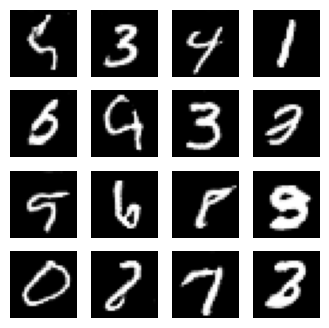

Epoch [19/30], Step [0/938], D Loss: 1.4368, G Loss: 0.8202
Epoch [19/30], Step [100/938], D Loss: 1.3169, G Loss: 1.0205
Epoch [19/30], Step [200/938], D Loss: 1.3283, G Loss: 0.8659
Epoch [19/30], Step [300/938], D Loss: 1.2996, G Loss: 0.9539
Epoch [19/30], Step [400/938], D Loss: 1.3395, G Loss: 0.9268
Epoch [19/30], Step [500/938], D Loss: 1.3295, G Loss: 0.7632
Epoch [19/30], Step [600/938], D Loss: 1.3582, G Loss: 0.8525
Epoch [19/30], Step [700/938], D Loss: 1.2709, G Loss: 0.8969
Epoch [19/30], Step [800/938], D Loss: 1.3445, G Loss: 0.8936
Epoch [19/30], Step [900/938], D Loss: 1.3837, G Loss: 0.9341


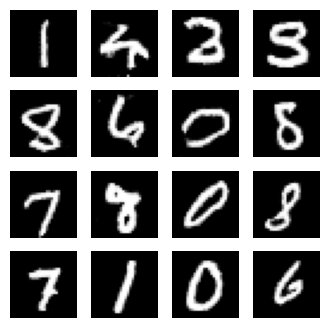

Epoch [20/30], Step [0/938], D Loss: 1.3975, G Loss: 0.7696
Epoch [20/30], Step [100/938], D Loss: 1.2925, G Loss: 0.9769
Epoch [20/30], Step [200/938], D Loss: 1.3718, G Loss: 0.9175
Epoch [20/30], Step [300/938], D Loss: 1.2709, G Loss: 0.8853
Epoch [20/30], Step [400/938], D Loss: 1.3453, G Loss: 0.9105
Epoch [20/30], Step [500/938], D Loss: 1.3402, G Loss: 0.8811
Epoch [20/30], Step [600/938], D Loss: 1.2715, G Loss: 0.9150
Epoch [20/30], Step [700/938], D Loss: 1.2379, G Loss: 0.9399
Epoch [20/30], Step [800/938], D Loss: 1.3162, G Loss: 0.7761
Epoch [20/30], Step [900/938], D Loss: 1.2779, G Loss: 0.8674


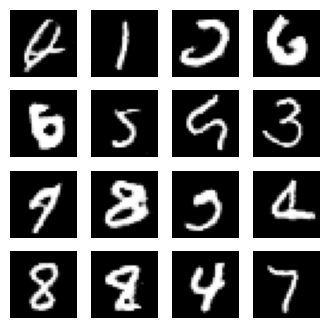

Epoch [21/30], Step [0/938], D Loss: 1.3461, G Loss: 0.8907
Epoch [21/30], Step [100/938], D Loss: 1.2909, G Loss: 1.0099
Epoch [21/30], Step [200/938], D Loss: 1.3986, G Loss: 0.8119
Epoch [21/30], Step [300/938], D Loss: 1.4201, G Loss: 0.8499
Epoch [21/30], Step [400/938], D Loss: 1.3137, G Loss: 0.7874
Epoch [21/30], Step [500/938], D Loss: 1.3324, G Loss: 0.8165
Epoch [21/30], Step [600/938], D Loss: 1.3084, G Loss: 0.9418
Epoch [21/30], Step [700/938], D Loss: 1.3694, G Loss: 0.8263
Epoch [21/30], Step [800/938], D Loss: 1.3004, G Loss: 0.8586
Epoch [21/30], Step [900/938], D Loss: 1.3187, G Loss: 0.9078


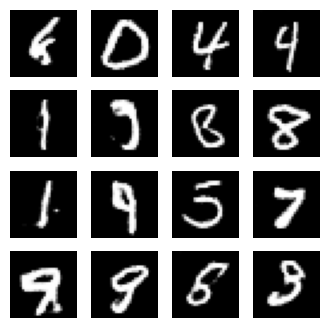

Epoch [22/30], Step [0/938], D Loss: 1.3243, G Loss: 0.9914
Epoch [22/30], Step [100/938], D Loss: 1.2586, G Loss: 0.8300
Epoch [22/30], Step [200/938], D Loss: 1.3990, G Loss: 0.7895
Epoch [22/30], Step [300/938], D Loss: 1.5085, G Loss: 0.6814
Epoch [22/30], Step [400/938], D Loss: 1.3251, G Loss: 0.8413
Epoch [22/30], Step [500/938], D Loss: 1.3872, G Loss: 0.7351
Epoch [22/30], Step [600/938], D Loss: 1.4501, G Loss: 0.9030
Epoch [22/30], Step [700/938], D Loss: 1.4120, G Loss: 0.8311
Epoch [22/30], Step [800/938], D Loss: 1.3726, G Loss: 0.7582
Epoch [22/30], Step [900/938], D Loss: 1.3613, G Loss: 0.8106


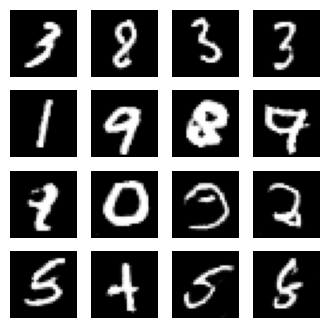

Epoch [23/30], Step [0/938], D Loss: 1.3298, G Loss: 0.8767
Epoch [23/30], Step [100/938], D Loss: 1.3954, G Loss: 0.8885
Epoch [23/30], Step [200/938], D Loss: 1.2607, G Loss: 0.8866
Epoch [23/30], Step [300/938], D Loss: 1.3605, G Loss: 0.8771
Epoch [23/30], Step [400/938], D Loss: 1.3866, G Loss: 0.7938
Epoch [23/30], Step [500/938], D Loss: 1.3787, G Loss: 0.9006
Epoch [23/30], Step [600/938], D Loss: 1.3363, G Loss: 0.8313
Epoch [23/30], Step [700/938], D Loss: 1.4502, G Loss: 0.7179
Epoch [23/30], Step [800/938], D Loss: 1.3861, G Loss: 0.7517
Epoch [23/30], Step [900/938], D Loss: 1.3742, G Loss: 0.7065


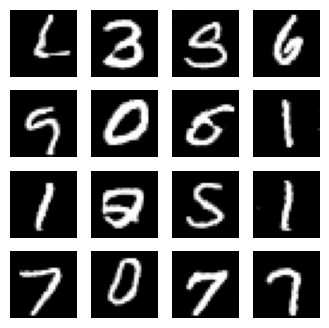

Epoch [24/30], Step [0/938], D Loss: 1.4167, G Loss: 0.7514
Epoch [24/30], Step [100/938], D Loss: 1.3828, G Loss: 0.8538
Epoch [24/30], Step [200/938], D Loss: 1.3931, G Loss: 0.7975
Epoch [24/30], Step [300/938], D Loss: 1.3051, G Loss: 0.7962
Epoch [24/30], Step [400/938], D Loss: 1.3145, G Loss: 0.8951
Epoch [24/30], Step [500/938], D Loss: 1.3359, G Loss: 0.8204
Epoch [24/30], Step [600/938], D Loss: 1.3056, G Loss: 0.8556
Epoch [24/30], Step [700/938], D Loss: 1.4298, G Loss: 0.7623
Epoch [24/30], Step [800/938], D Loss: 1.3638, G Loss: 0.7034
Epoch [24/30], Step [900/938], D Loss: 1.3344, G Loss: 0.7933


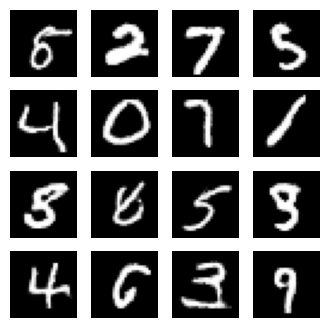

Epoch [25/30], Step [0/938], D Loss: 1.3060, G Loss: 0.9263
Epoch [25/30], Step [100/938], D Loss: 1.3890, G Loss: 0.8690
Epoch [25/30], Step [200/938], D Loss: 1.4286, G Loss: 0.8315
Epoch [25/30], Step [300/938], D Loss: 1.3179, G Loss: 0.7659
Epoch [25/30], Step [400/938], D Loss: 1.4314, G Loss: 0.7936
Epoch [25/30], Step [500/938], D Loss: 1.3710, G Loss: 0.8101
Epoch [25/30], Step [600/938], D Loss: 1.3649, G Loss: 0.9519
Epoch [25/30], Step [700/938], D Loss: 1.3999, G Loss: 0.7658
Epoch [25/30], Step [800/938], D Loss: 1.4464, G Loss: 0.8128
Epoch [25/30], Step [900/938], D Loss: 1.4151, G Loss: 0.7101


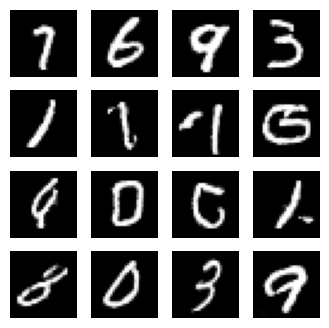

Epoch [26/30], Step [0/938], D Loss: 1.4398, G Loss: 0.7923
Epoch [26/30], Step [100/938], D Loss: 1.3243, G Loss: 0.8310
Epoch [26/30], Step [200/938], D Loss: 1.3487, G Loss: 0.7948
Epoch [26/30], Step [300/938], D Loss: 1.4403, G Loss: 0.8357
Epoch [26/30], Step [400/938], D Loss: 1.3602, G Loss: 0.8191
Epoch [26/30], Step [500/938], D Loss: 1.3807, G Loss: 0.8329
Epoch [26/30], Step [600/938], D Loss: 1.3242, G Loss: 0.9046
Epoch [26/30], Step [700/938], D Loss: 1.3462, G Loss: 0.9740
Epoch [26/30], Step [800/938], D Loss: 1.3824, G Loss: 0.8406
Epoch [26/30], Step [900/938], D Loss: 1.3253, G Loss: 0.7830


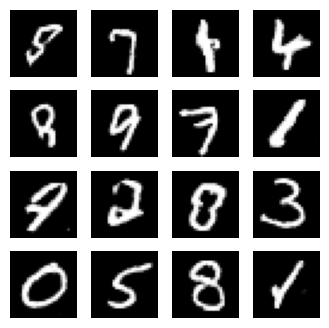

Epoch [27/30], Step [0/938], D Loss: 1.3665, G Loss: 0.7794
Epoch [27/30], Step [100/938], D Loss: 1.3737, G Loss: 0.8402
Epoch [27/30], Step [200/938], D Loss: 1.3947, G Loss: 0.7454
Epoch [27/30], Step [300/938], D Loss: 1.4755, G Loss: 0.8334
Epoch [27/30], Step [400/938], D Loss: 1.3334, G Loss: 0.9708
Epoch [27/30], Step [500/938], D Loss: 1.2818, G Loss: 0.8746
Epoch [27/30], Step [600/938], D Loss: 1.3842, G Loss: 0.7928
Epoch [27/30], Step [700/938], D Loss: 1.3353, G Loss: 0.8383
Epoch [27/30], Step [800/938], D Loss: 1.3727, G Loss: 0.9146
Epoch [27/30], Step [900/938], D Loss: 1.3011, G Loss: 0.7713


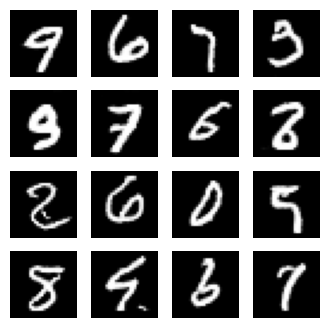

Epoch [28/30], Step [0/938], D Loss: 1.3494, G Loss: 0.8767
Epoch [28/30], Step [100/938], D Loss: 1.2525, G Loss: 0.8964
Epoch [28/30], Step [200/938], D Loss: 1.4166, G Loss: 0.7692
Epoch [28/30], Step [300/938], D Loss: 1.2906, G Loss: 0.8902
Epoch [28/30], Step [400/938], D Loss: 1.3271, G Loss: 0.7970
Epoch [28/30], Step [500/938], D Loss: 1.4553, G Loss: 0.7578
Epoch [28/30], Step [600/938], D Loss: 1.4026, G Loss: 0.8924
Epoch [28/30], Step [700/938], D Loss: 1.3062, G Loss: 0.8050
Epoch [28/30], Step [800/938], D Loss: 1.2706, G Loss: 0.9109
Epoch [28/30], Step [900/938], D Loss: 1.3818, G Loss: 0.8103


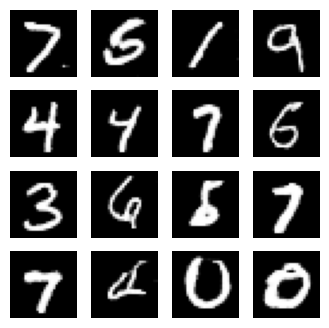

Epoch [29/30], Step [0/938], D Loss: 1.4108, G Loss: 0.7865
Epoch [29/30], Step [100/938], D Loss: 1.3806, G Loss: 0.7805
Epoch [29/30], Step [200/938], D Loss: 1.3877, G Loss: 0.9198
Epoch [29/30], Step [300/938], D Loss: 1.3255, G Loss: 0.8144
Epoch [29/30], Step [400/938], D Loss: 1.3474, G Loss: 0.7158
Epoch [29/30], Step [500/938], D Loss: 1.3052, G Loss: 0.9207
Epoch [29/30], Step [600/938], D Loss: 1.3655, G Loss: 0.8028
Epoch [29/30], Step [700/938], D Loss: 1.4000, G Loss: 0.8105
Epoch [29/30], Step [800/938], D Loss: 1.3661, G Loss: 0.8238
Epoch [29/30], Step [900/938], D Loss: 1.3371, G Loss: 0.8794


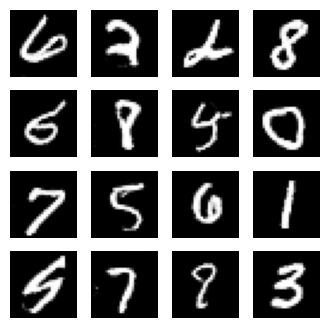

Epoch [30/30], Step [0/938], D Loss: 1.2703, G Loss: 0.7476
Epoch [30/30], Step [100/938], D Loss: 1.3486, G Loss: 0.8176
Epoch [30/30], Step [200/938], D Loss: 1.3269, G Loss: 0.8689
Epoch [30/30], Step [300/938], D Loss: 1.3381, G Loss: 0.8320
Epoch [30/30], Step [400/938], D Loss: 1.4006, G Loss: 0.6967
Epoch [30/30], Step [500/938], D Loss: 1.3141, G Loss: 0.7907
Epoch [30/30], Step [600/938], D Loss: 1.3677, G Loss: 0.7193
Epoch [30/30], Step [700/938], D Loss: 1.4032, G Loss: 0.8050
Epoch [30/30], Step [800/938], D Loss: 1.3652, G Loss: 0.8236
Epoch [30/30], Step [900/938], D Loss: 1.3819, G Loss: 0.8331


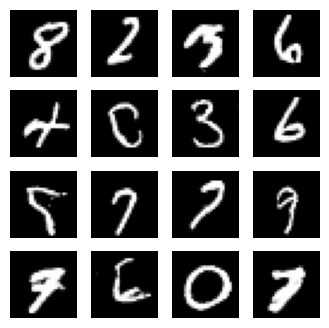

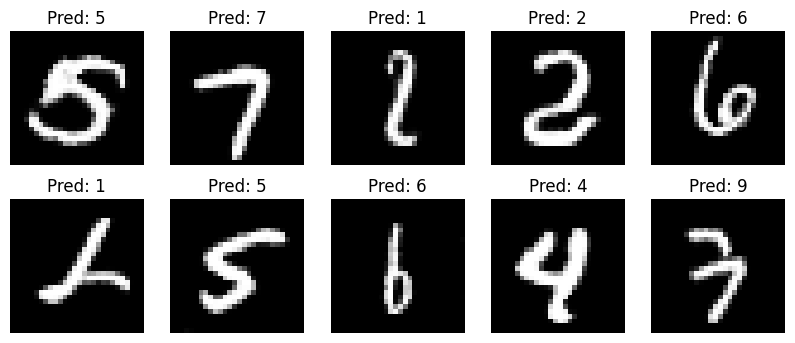

In [21]:
# Розмір вектору шуму, який подаємо на вхід Генератору
z_dim = 100

# Розмір зображення MNIST після "розгортання" в вектор
img_size = 28 * 28

optimizer_g_params = {"lr": 0.0002, "betas": (0.5, 0.999)}
optimizer_d_params = {"lr": 0.0002, "betas": (0.5, 0.999)}

generator = DCGANGenerator(z_dim=z_dim)
discriminator = DCGANDiscriminator()

trainer = Trainer(
    generator=generator,
    discriminator=discriminator,
    batch_size=64,
    device="cuda" if torch.cuda.is_available() else "cpu",
    optimizer_g=optim.Adam,
    optimizer_d=optim.Adam,
    optimizer_g_par=optimizer_g_params,
    optimizer_d_par=optimizer_d_params,
)

trainer.test_output

trainer.train(train_loader, 'gan', num_epochs=30)

## Висновки

### 1. **Найкраща архітектура**
Архітектура **DCGAN (Deep Convolutional GAN)** показала найкращі результати серед реалізованих, виходячи з аналізу якості згенерованих зображень, стабільності навчання, та метрик втрат генератора й дискримінатора.

#### Чому DCGAN виявилась найефективнішою:
- **Згорткові шари** дозволяють ефективніше захоплювати просторові залежності в зображеннях, що особливо важливо для набору даних MNIST, де структура цифр має ключове значення.
- **Batch Normalization** в генераторі та дискримінаторі стабілізує процес навчання, запобігаючи градієнтним вибухам чи зниканню.
- **Leaky ReLU** як активація для дискримінатора забезпечує краще навчання через уникнення "мертвих нейронів".

### 2. **Вплив методів налаштування**
Кілька методів мали помітний вплив на продуктивність моделей:

#### **Розмір батчу**
Експерименти з різними розмірами батчів показали:
- **Оптимальний розмір:** Батч розміром 64 надав стабільний баланс між швидкістю навчання та якістю генерації. Збільшення батчу (до 128) сприяло стабільності, але сповільнювало конвергенцію.

#### **Коефіцієнт навчання**
- **Learning Rate для Adam:** Значення `0.0002` для генератора і дискримінатора було оптимальним. Занадто великі значення призводили до коливань втрат, а занадто маленькі сповільнювали навчання.

#### **Dropout**
- Додавання Dropout до дискримінатора (ймовірність 0.4) допомогло запобігти перенавчанню, особливо на пізніх етапах.

#### **Оптимізатори**
- **Adam** виявився найкращим для базових GAN і DCGAN завдяки своєму адаптивному характеру.
- **RMSProp** показав себе добре у WGAN, де використання кліпінгу ваг було важливим.

#### **Функції втрат**
- Вибір функцій втрат, зокрема Wasserstein Loss у WGAN, значно покращив стабільність навчання, усунувши проблему зникаючих градієнтів, притаманну класичним GAN.

### 3. **Інші спостереження**
- Conditional GAN (cGAN) має потенціал у задачах, де необхідна генерація контрольованих зображень (наприклад, цифр заданих класів), але вимагає більше ресурсів і точного налаштування для досягнення високої якості.
- WGAN відзначився стабільністю навчання, але потребував більше обчислювальних ресурсів через часті оновлення критика.

### Загальний висновок
- **DCGAN** найкраще підходить для задачі генерації рукописних цифр на MNIST завдяки своїй здатності зберігати просторові характеристики.
- Найбільший вплив на якість моделей мали налаштування **розміру батчу**, **коефіцієнта навчання** та використання **Dropout**.
